# Exploring MA-XRF data with `maxrf4u` 

*Why all this is needed.* 

In [ ]:
%load_ext autoreload
%autoreload 2 

In [ ]:
cd '/home/frank/Work/Projecten/DoRe/viz/raw_nmf'

/mnt/datadisk/Work/Projecten/DoRe/viz/raw_nmf


In [ ]:
%matplotlib notebook

In [ ]:
import maxrf4u 

## `__init__.py` 

In [ ]:
%%writefile /home/frank/Work/Projecten/DoRe/code/maxrf4u/__init__.py 
from .storage import *
from .calibration import * 
from .hotmax import * 

Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/__init__.py


## Storage 

### Creating a .datastack file to do out-of-memory calculations 

Macro-X-Ray-Fluorescence (MA-XRF) data typically do not fit into memory. In order to make optimal use of your computer memory and processors it is therefore necessary to convert such spectral data into a chunked analysis-ready file format. The `maxrf4u` package makes use of a specially developed `.datastack` file format. This format is based on [zarr](https://zarr.readthedocs.io/en/stable/) ZipStore.

In this example below we show how to convert a MA-XRF dataset  consisting of a `.raw` data cube file (and an `.rpl` shape file) into a `.datastack` file. On my laptop this initial conversion of a 21 Gb dataset takes 7:22 minutes...  

In [ ]:
cd '/home/frank/Work/Projecten/DoRe/viz/raw_nmf' 

/mnt/datadisk/Work/Projecten/DoRe/viz/raw_nmf


In [ ]:
!ls -lh

total 46G
-rw-rw-r-- 1 frank frank 26G dec 28 12:53 RP-T-1898-A-3689.datastack
-rwxrwxrwx 1 frank frank 21G mrt  9  2021 RP-T-1898-A-3689.raw
-rwxrwxrwx 1 frank frank 181 mrt  9  2021 RP-T-1898-A-3689.rpl


In [ ]:
maxrf4u.raw_to_datastack('RP-T-1898-A-3689.raw', 'RP-T-1898-A-3689.rpl')

Writing: RP-T-1898-A-3689.datastack...
[########################################] | 100% Completed |  4min 49.2s
Computing max spectrum...
[########################################] | 100% Completed |  1min 19.3s
Computing sum spectrum...
[########################################] | 100% Completed |  1min 18.5s


It is now possible to check the content (i.e. the datasets) of the .datastack file with the `tree()` function. 

In [ ]:
maxrf4u.tree('RP-T-1898-A-3689.datastack')

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


With the `show_arrays=True` option the `tree()` function also shows the shapes of the individual datasets. 

In [ ]:
maxrf4u.tree('RP-T-1898-A-3689.datastack', show_arrays=True)

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


With the freshly created `.datastack` file it is now possible to explore and process the data. Let's start this exploration by plotting numpy arrays that are returned by the `max_spectrum()` and `sum_spectrum()` convenience methods. The max and sum spectra provide a good summary of the spectral data. The horizontal axis shows the detector channel numbers. Note that inconveniently the data does not provide an energy calibration. 

In [ ]:
ds = maxrf4u.DataStack('RP-T-1898-A-3689.datastack', verbose=True)

RP-T-1898-A-3689.datastack:

/
 ├── hotmax_pixels (24, 3) int64
 ├── hotmax_spectra (24, 4096) float32
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_energies (4096,) float64
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


In [ ]:
y_max

dask.array<array, shape=(4096,), dtype=float32, chunksize=(4096,), chunktype=numpy.ndarray>

<IPython.core.display.Javascript object>


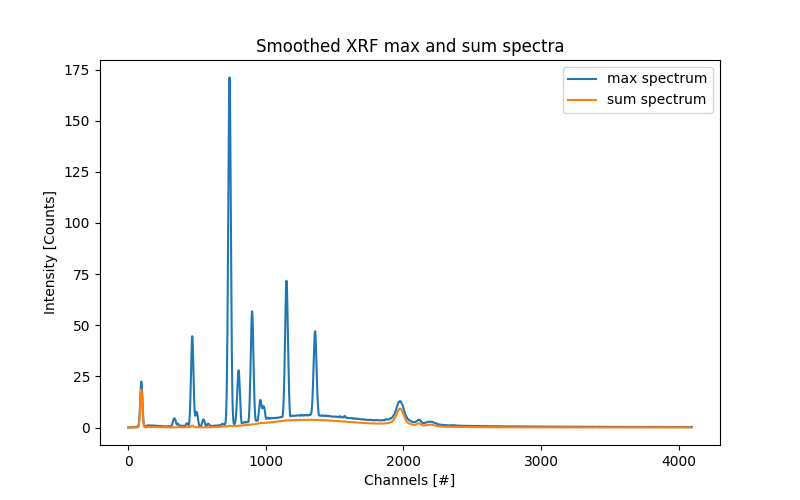

In [ ]:
import matplotlib.pyplot as plt 

#y_max = ds.maxspectrum()
#y_sum = ds.sumspectrum()

y_max = ds.read('maxrf_maxspectrum')
y_sum = ds.maxrf

fig, ax = plt.subplots(figsize=[8, 5])
ax.plot(y_max, label='max spectrum')
ax.plot(y_sum, label='sum spectrum')
ax.set_title('Smoothed XRF max and sum spectra')
ax.set_xlabel('Channels [#]')
ax.set_ylabel('Intensity [Counts]')
ax.legend();

### `maxrf4u.storage.py` 

In [ ]:
%%writefile /home/frank/Work/Projecten/DoRe/code/maxrf4u/storage.py 

# See development notebook: ~/Work/Projecten/DoRe/notebooks/2021-03-05-maxrf4u-dev.ipynb

import maxrf4u

import numpy as np 
import dask 
import dask.array as da 
from dask.diagnostics import ProgressBar 
import dask_ndfilters 
import re 
import os 
import zarr 
from IPython.display import HTML 
import cv2
import matplotlib.pyplot as plt 
import scipy.signal as ssg 
import time 


# CONSTANTS 
DATASTACK_EXT = '.datastack' 

# datastack layer one 
MAXRF_CUBE = 'maxrf_cube'
MAXRF_MAXSPECTRUM = 'maxrf_maxspectrum'
MAXRF_SUMSPECTRUM = 'maxrf_sumspectrum'
MAXRF_ENERGIES = 'maxrf_energies'

# datastack layer two  
HOTMAX_SPECTRA = 'hotmax_spectra'
HOTMAX_PIXELS = 'hotmax_pixels' 
HOTMAX_INTENSITIES = 'hotmax_intensities'

# datastack layer three 
MAPS_IMVIS = 'maps_imvis'


# functions 

def raw_to_datastack(raw_file, rpl_file, datastack_file=None, datapath=MAXRF_CUBE, verbose=True): 
    '''Convert Bruker Macro XRF (.raw) data file *raw_filename* and (.rpl) shape file *rpl_filename*.  
    
    into a Zarr Zipstore datastack file (.datastack).'''
    
    # generate datastack filename from .raw 
    if datastack_file is None: 
        datastack_file = re.sub('\.raw$', DATASTACK_EXT, raw_file) 
        
    # read data cube shape from .rpl file 
    with open(rpl_file, 'r') as fh: 
        lines = fh.readlines()

    # get rid of spaces and newline characters 
    keys_and_values = dict([re.sub(' |\n', '', l).split('\t') for l in lines]) 

    width = int(keys_and_values['width'])
    height = int(keys_and_values['height'])
    depth = int(keys_and_values['depth'])

    shape = (height, width, depth)
    
    # create numpy memory map 
    raw_mm = np.memmap(raw_file, dtype='uint16', mode='r', shape=(height, width, depth))[::-1, ::-1] 

    # initializing dask array 
    arr = da.from_array(raw_mm) 
    arr = arr.astype(np.float32)

    # schedule spectral gaussian smoothing computation 
    smoothed = dask_ndfilters.gaussian_filter(arr, (0, 0, 7)) 

    # create and open an empty zip file
    zs = zarr.ZipStore(datastack_file, mode='w') 
    
    if verbose: 
        print(f'Writing: {datastack_file}...')

    # compute and write maxrf data to zipstore 
    with ProgressBar(): 
        smoothed.to_zarr(zs, component=datapath) 
        
    zs.close()
    
    # compute sum and max spectra and append to zipstore 
    
    y_max, y_sum = max_and_sum_spectra(datastack_file, datapath=MAXRF_CUBE)
    
    append(y_max, MAXRF_MAXSPECTRUM, datastack_file)
    append(y_sum, MAXRF_SUMSPECTRUM, datastack_file)
    
    

def tree(datastack_file, show_arrays=False): 
    '''Prints content tree of *datastack_file* '''

    with zarr.ZipStore(datastack_file, mode='r') as zs: 
        root = zarr.group(store=zs) 
        tree = root.tree(expand=True).__repr__()
        print(f'{datastack_file}:\n\n{tree}')  
        
        if show_arrays:        
            datasets = sorted(root)
            arrays_html = ''

            for ds in datasets: 
                arr = da.from_array(root[ds])
                html = arr._repr_html_()
                arrays_html = f'{arrays_html}- Dataset: <h style="color:brown">{ds}</h>{html}' 
   
            return HTML(arrays_html)

def underscorify(datapath, datapath_list, extra_underscore=True): 
    '''Append extra underscore if *datapath* exists to prevent overwriting. 
    
    If *extra_underscore=False* return (latest) datapath with most underscores'''
    
    if datapath in datapath_list: 
        r = re.compile(f'{datapath}_*$')
        datapath = sorted(filter(r.match, datapath_list))[-1]
        
        if extra_underscore: 
            datapath = datapath + '_'
        
    return datapath 


def append(arr, datapath, datastack_file): 
    '''Add numpy or dask array *arr* to *datastack_file* in folder *datapath*.'''
    
    if not isinstance(arr, dask.array.Array):  
        arr = da.from_array(arr) 
            
    with zarr.ZipStore(datastack_file, mode='a') as zs: 
        root = zarr.group(store=zs)
        
        # append underscores to make unique if datapath exists 
        datapath_list = sorted(root) 
        datapath = underscorify(datapath, datapath_list)
        
        # write      
        arr.to_zarr(zs, component=datapath)



def repack(datastack_file, select='all', overwrite=True, verbose=False): 
    '''Repack *datastack_file* by deleting and renaming all but latest datasets. 
    
    Automatic selection of latest datasets can be overriden be providing list of *select* datasets''' 
    
    if verbose: 
        tree(datastack_file)
    
    # open existing zipstore  
    zs = zarr.ZipStore(datastack_file, mode='r') 
    root = zarr.group(store=zs)
    datapath_list = sorted(root)  
    
    # select newest version (most underscores) for all datasets
    if select is 'all': 
        selected = sorted(set([underscorify(dp, datapath_list, extra_underscore=False) for dp in datapath_list])) 
    # select newest version (most underscores) for datasets in select
    else: 
        selected = sorted(set([underscorify(dp, datapath_list, extra_underscore=False) for dp in select]))       
    
    # remove underscores 
    renamed = [re.sub('_*$', '', s) for s in selected] 
    
    # create and open new empty zipstore 
    datastack_file_new = datastack_file + '_temp'
    zs_new = zarr.ZipStore(datastack_file_new, mode='w') 
    
    # copy selected datasets into new zipstore 
    with ProgressBar(): 
        for src, dst in zip(selected, renamed): 
            print(f'Repacking dataset: \'{src}\'') 
            arr = da.from_array(root[src])
            arr.to_zarr(zs_new, component=dst)
    
    zs.close()
    zs_new.close()
    
    # finally overwrite old with new  
    if overwrite: 
        os.replace(datastack_file_new, datastack_file)
    
    if verbose:
        print()
        tree(datastack_file)
        

def max_and_sum_spectra(datastack_file, datapath=MAXRF_CUBE): 
    '''Compute sum spectrum and max spectrum for 'maxrf' dataset in *datastack_file*. 
    
    Returns: *y_sum*, *y_max*'''
    
    # open existing zipstore  
    zs = zarr.ZipStore(datastack_file, mode='r') 
    root = zarr.group(store=zs)
    
    # initialize dask array 
    arr = da.from_array(root[datapath])
        
    # flatten
    h, w, d = arr.shape
    arr_flat = arr.reshape([h*w, d]) 
    
    # schedule computations 
    sum_spectrum = arr_flat.sum(axis=0)
    max_spectrum = arr_flat.max(axis=0)
    
    # compute 
    print('Computing max spectrum...')
    with ProgressBar():
        y_max = max_spectrum.compute() 
    print('Computing sum spectrum...')
    with ProgressBar(): 
        y_sum = sum_spectrum.compute() / (h * w)
        
    zs.close()
     
    return y_max, y_sum 


        
class DataStack: 
    
    def __init__(self, datastack_file, mode='r', verbose=False, show_arrays=True): 
        '''Initialize DataStack object from *datastack_file*.'''
        
        self.mode = mode 
        self.datastack_file = datastack_file 
        
        self.update_attrs()
            
        # print tree 
        if verbose: 
            tree(self.datastack_file, show_arrays=show_arrays) 
            
    def update_attrs(self): 
        
        # populate store attributes 
        self.store = zarr.ZipStore(self.datastack_file, mode=self.mode) 
        self.root = zarr.group(store=self.store) 
        
        # generic exposure to dask arrays 
        self.datapath_list = sorted(self.root) 
        self.datasets = {dp: da.from_array(self.root[dp]) for dp in self.datapath_list}
        
        # attributify dask arrays 
        # useful for code development, perhaps confusing for users 
        # might turn off this feature later 
        for dp, ds in self.datasets.items(): 
            setattr(self, dp, ds) 
        
            
    def latest(self, datapath): 
        '''Return latest version of datapath. '''
        
        datapath = underscorify(datapath, self.datapath_list, extra_underscore=False)
        
        return datapath 
        
            
    def read(self, datapath, latest=True, compute=True):
        '''Read latest version of dataset for *datapath*
        
        Returns numpy array if dataset exists. Otherwise returns None. '''
        
        if datapath in self.datapath_list: 
            if latest: 
                datapath = self.latest(datapath)     
            dataset = self.datasets[datapath] 
            if compute: 
                dataset = dataset.compute()
        else: 
            dataset = None 
    
        return dataset

    
    def tree(self, show_arrays=False): 
        '''Prints content tree of datastack.'''
        
        tree(self.datastack_file, show_arrays=show_arrays)
            
                    
    def read_maxspectrum(self): 
        '''Convenience method. Returns latest numpy array of max spectrum dataset. '''
        
        dataset = self.read(MAXRF_MAXSPECTRUM) 
        
        return dataset
        
    
    def read_sumspectrum(self): 
        '''Convenience method. Returns numpy array of sum spectrum dataset. '''
        
        dataset = self.read(MAXRF_SUMSPECTRUM) 
        
        return dataset
        

    def read_energies(self): 
        '''Convenience method. Returns latest numpy array of channel energies (in keV units).
        
        If not yet available from datastack, calibrate, inspect and save. '''
        
        x_keVs = self.read(MAXRF_ENERGIES) 
        
        
        if x_keVs is None: 
            print('This datastack does not contain a required channel energy calibration.')
            print('Please calibrate now.')
        
            x_keVs = maxrf4u.calibrate(self.datastack_file)
                
            # update attributes 
            self.update_attrs()
             
        return x_keVs
    
    def read_hotmax(self, prominence=0.35):  
        '''Convenience method. Returns numpy arrays of hotmax pixels and corresponding hotmax spectra. 
        
        If available from datastack file, otherwise, calibrate, inspect and save. '''
        
        hotmax_pixels = self.read(HOTMAX_PIXELS) 
        hotmax_spectra = self.read(HOTMAX_SPECTRA) 
    
        if (hotmax_spectra is None) or (hotmax_pixels is None): 
            
            print('Datastack file does not yet contain required hotmax data layer.')
            print('Locating hotmax pixels and spectra now: ')
             
            hotmax_pixels, hotmax_spectra  = maxrf4u.get_hotmax(self.datastack_file, prominence=prominence) 
            
            # update attributes 
            self.update_attrs()

        return hotmax_pixels, hotmax_spectra 
             
        
#   def calibrate(self, anode='Rh', prominence=0.1, plot=True, datapath=MAXRF_ENERGIES): 
#       '''Auto-calibrate dataset channel energies and write to datastack if user affirms. '''
#       
#       y_max = self.read(MAXRF_MAXSPECTRUM)
#       y_sum = self.read(MAXRF_SUMSPECTRUM)
#       
#       keVs = maxrf4u.calibrate(y_max, y_sum, anode=anode, prominence=prominence, plot=plot)
#       
#       # write keVs 
#       write = input('Write energy calibration to datastack file [y/n]? ')
#        
#       if write == 'y': 
#           print('\nWriting channel energies (keV)...\n')
#           maxrf4u.append(keVs, datapath, self.datastack_file) 
#           maxrf4u.tree(self.datastack_file)
#           
#           # update attributes 
#           self.update_attrs()
#           
                
    def close(self): 
        '''Close file handle'''
         
        self.store.close()
        self.mode = 'closed' 
        
        print(f'Closed: {self.datastack_file}') 
        

Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/storage.py


In [ ]:
# force deep reload 
import maxrf4u
import sys
del sys.modules['maxrf4u.calibration']
del sys.modules['maxrf4u.storage']
del sys.modules['maxrf4u']

import maxrf4u

## Calibration 

### Energy calibration 

Inconveniently, ma-xrf data does not always include information about the energy calibration of the spectra. Thus, a very first step in the data analysis is to obtain the energy calibration in keV units (kilo-electron-Volt) for a given dataset. Fortunately, XRF spectra, (at least for drawings), typically have two clearly recognizable features that allow for energy calibration of the detector channels. The automatic energy calibration is done in two steps. 

In the first step the dominant broad Compton peak is observed in the sum spectrum. The position of this peak can not be used for the calibration directly due to an unknown (detector angle specific) Compton shift, but it serves as a landmark. Right next to the Compton peak a small peak is found. In our lab an x-ray tube with a Rhodium anode is used. This peak can now be attributed to elastic scattering of the strong Rhodium K-alpha emission peak present in the x-ray tube spectrum at 20.21 keV.   

In the second step of the calibration process the iron K-alpha emission peak is located in the max spectrum. Essentially all artifacts like paper contain iron, with a known strong emission K-alpha line at 6.403 keV.  

As a first requisite step in the data analysis the function `calibrate()` is called. The user is prompted to inspect and save the result.   

<IPython.core.display.Javascript object>


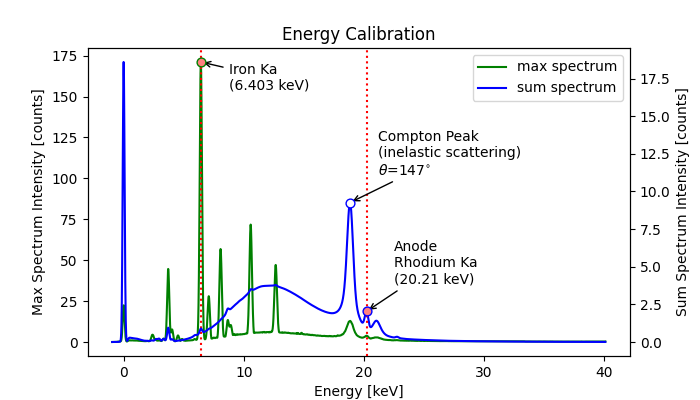

Write energy calibration to datastack file [y/n]? n


In [ ]:
from maxrf4u import calibrate, DataStack

x_keVs = calibrate('RP-T-1898-A-3689.datastack')

In further analysis our stored energy calibration can now be accessed using the `DataStack.read_energies()` method which returns an array with 4096 energy values. 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')
x_keVs = ds.read_energies()
print(x_keVs)

[-0.98188629 -0.97185221 -0.96181812 ... 40.08763102 40.09766511
 40.1076992 ]


In [ ]:
print(f'Number of energy channels: {len(x_keVs)}')

Number of energy channels: 4096


### `maxrf4u.calibration.py`

In [ ]:
%%writefile /home/frank/Work/Projecten/DoRe/code/maxrf4u/calibration.py 

# See development notebook: ~/Work/Projecten/DoRe/notebooks/2021-03-05-maxrf4u-dev.ipynb 

import maxrf4u 
import matplotlib.pyplot as plt 
import numpy as np 
import scipy.signal as ssg 
import matplotlib.cm as cm 
import math

RHODIUM_Ka = 20.210105052526263 # Rh_KL3 
IRON_Ka = 6.4032016008004 # Fe_KL3 

def calibrate(datastack_file, anode='Rh', prominence=0.1): 
    '''Automatic two step energy energy calibration. 
    
    1) In step 1 a preliminary calibration is done assuming that the  
    sensor peak is located at 0 keV and the Rhodium anode Ka peak 
    is next to it's high and broad Compton scattering peak in the sum spectrum. 
    
    2) This preliminary calibration the enables the identification of Fe_Ka and a 
    second precise calibration.'''
    
    assert anode == 'Rh', NotImplementedError('Sorry, need to implement other anode materials!') 
    
    ds = maxrf4u.DataStack(datastack_file)
    
    y_max = ds.read_maxspectrum()
    y_sum = ds.read_sumspectrum()
    
    #RHODIUM_Ka = 20.210105052526263 # Rh_KL3 
    #IRON_Ka = 6.4032016008004 # Fe_KL3 

    # find sensor and anode peaks in sum spectrum 
    n_channels = len(y_sum) 
    x_indices = np.arange(n_channels)
    sum_peak_indices, shapes_dict = ssg.find_peaks(y_sum, prominence=prominence)
    max_peak_indices, shapes_dict = ssg.find_peaks(y_max, prominence=prominence)
    peaks_y = y_sum[sum_peak_indices]
    
    # STEP 1: PRELIMINARY SENSOR + ANODE CALIBRATION TO LOCATE IRON Fe_Ka PEAK  

    # clean spectrum by removing (typically highest) sensor peak  
    n_sensor = n_channels // 20
    y_sum_clean = y_sum.copy()
    y_sum_clean[0:n_sensor] = 0 

    # Now assume highest peak in clean spectrum 
    # is Compton scattering of anode Ka emission  
    compton_i = np.argmax(y_sum_clean) 
    
    # find anode peak channel index right next to Compton peak    
    right_peak_i = sum_peak_indices[list(sum_peak_indices).index(compton_i) + 1] 
    right_keV = RHODIUM_Ka

    # assume sensor peak energy is zero   
    left_peak_i = sum_peak_indices[0]
    left_keV = 0

    # determine sensor + anode based preliminary calibration 
    slope = (right_keV - left_keV) / (right_peak_i - left_peak_i) 
    offset = left_keV - slope * left_peak_i  
    keVs_precalib = slope * x_indices + offset 

    # STEP 2: PRECISE IRON Ka + ANODE CALIBRATION   
    peak_keVs_precalib = keVs_precalib[max_peak_indices]

    # now find index of peak nearest to Fe_Ka energy 
    iron_peak_i = np.argmin((peak_keVs_precalib - IRON_Ka)**2)
    
    # calibrate again now with iron Ka left hand peak 
    
    left_peak_i = max_peak_indices[iron_peak_i]
    left_keV = IRON_Ka

    slope = (right_keV - left_keV) / (right_peak_i - left_peak_i) 
    offset = left_keV - slope * left_peak_i  
    x_keVs = slope * x_indices + offset 
    
    # Calibration peak diagnostics 
    iron_xy = x_keVs[left_peak_i], y_max[left_peak_i]
    compton_xy = x_keVs[compton_i], y_sum[compton_i]
    anode_xy = x_keVs[right_peak_i], y_sum[right_peak_i] 
    
    theta = detector_angle(compton_xy[0], anode_xy[0])
    
    calib_peaks_x, calib_peaks_y = np.array([iron_xy, compton_xy, anode_xy]).T 
    
    # Create calibration plot 
    plt.ion()

    colors =  cm.tab10([0, 1, 2]) 
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[7, 4])
    ax2 = ax.twinx()
    line1, = ax.plot(x_keVs, y_max, label='max spectrum', color='green')
    line2, = ax2.plot(x_keVs, y_sum, label='sum spectrum', color='blue')


    # annotate iron in max spectrum 
    ax.axvline(iron_xy[0], linestyle=':', color='r')
    ax.annotate(f'Iron Ka \n({iron_xy[0]:.3f} keV)', iron_xy, xytext=[20, -20], 
                textcoords='offset points', ha='left', 
                arrowprops=dict(arrowstyle="->", facecolor='grey'))
    ax.scatter(*iron_xy, s=40, facecolor=[1, 0.5, 0.5], edgecolor='green', zorder=10) 

    ax.set_title('Energy Calibration')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel('Max Spectrum Intensity [counts]')


    # annotate compton peak in sum spectrum 
    ax2.annotate('Compton Peak\n(inelastic scattering)\n' + 
                r'$\theta$' + f'={int(theta)}' + r'$^{\circ}$', 
                compton_xy, xytext=[20, 20], 
                textcoords='offset points', ha='left', 
                arrowprops=dict(arrowstyle="->", facecolor='grey'))
    ax2.scatter(*compton_xy, s=40, facecolor='white', edgecolor='blue', zorder=10)       

    # annotate anode peak in sum spectrum 
    ax2.axvline(anode_xy[0], linestyle=':', color='r')
    ax2.annotate(f'Anode\nRhodium Ka \n({anode_xy[0]:.2f} keV)', anode_xy, xytext=[20, 20], 
                textcoords='offset points', ha='left', 
                arrowprops=dict(arrowstyle="->", facecolor='grey'))
    ax2.scatter(*anode_xy, s=40, facecolor=[1, 0.5, 0.5], edgecolor=[0, 0, 1], zorder=10)        

    ax2.set_ylabel('Sum Spectrum Intensity [counts]')

    ax.legend(handles=[line1, line2], loc='upper right')

        
    # force updating plot 
    plt.pause(0.2)
    fig.canvas.draw()
        
    # write energies 
    write = input('Write energy calibration to datastack file [y/n]? ')

    if write == 'y': 
        print(f'\nWriting channel energies (keV) to: {datastack_file}')
        maxrf4u.append(x_keVs, maxrf4u.MAXRF_ENERGIES, ds.datastack_file) 
            
    return x_keVs


def detector_angle(keV0, keV1): 
    '''Calculate detector angle *theta* (degrees) 
    
    from Compton peak energy *keV0* and anode energy *keV1* and . '''
    
    assert keV0 < keV1, 'Compton energy should be less then anode energy'

    # constants 
    e = 1.602e-19 # electron charge
    pi = math.pi
    h = 6.62607e-34 # Planck constant 
    m0 = 9.10939e-31 # electron mass 
    c = 2.998e8 # speed of light 
    
    
    # convert keV to Joule 
    E0 = 1000 * keV0 * e 
    E1 = 1000 * keV1 * e 

    theta = (180 / pi) * np.arccos(1 - m0 * c**2 * (1/E0 - 1/E1))

    return theta

Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/calibration.py


In [ ]:
# force deep reload 
import maxrf4u
import sys
del sys.modules['maxrf4u.calibration']
del sys.modules['maxrf4u.storage']
del sys.modules['maxrf4u']

import maxrf4u 
import numpy as np 

## Hotmax spectra   

### Locating the hotmax pixels and spectra 

A MA-XRF spectral image data cube contains typically a million spectra or so. Far too many to analyze them individually! Furthermore, most of these spectra have low signals and are rather noisy. A common approach to overcome computational problems is to base a further data analysis solely on the max spectrum. Such an approach is used e.g. by *DataMunger* (Mathias Alfeld **need link here**). As discussed above, the max spectrum essentially is an envelope that provides a highly informative summary of all spectra. It is important to understand that different peaks in the max spectrum envelope can originate from different pixel positions in the spectral image. This complicates attribution of the peaks directly from the max spectrum. 

A more sophisticated approach is to locate for each peak in the max spectrum envelope which specific pixel spectrum is responsible for that specific peak. Loosely speaking, which pixels in the spectral image data cube are 'hotmax'? Another way to explain this is to find the specific 'hotmax' spectra that touches the corresponding max spectrum peaks.    

A requisite step in the data analysis now is to find the hotmax pixels and spectra. Locating them takes a few minutes, and should be done once using the `get_hotmax()` function. The user is prompted to inspect and save the result in the datastack file.   

In [ ]:
from maxrf4u import get_hotmax, DataStack

<IPython.core.display.Javascript object>


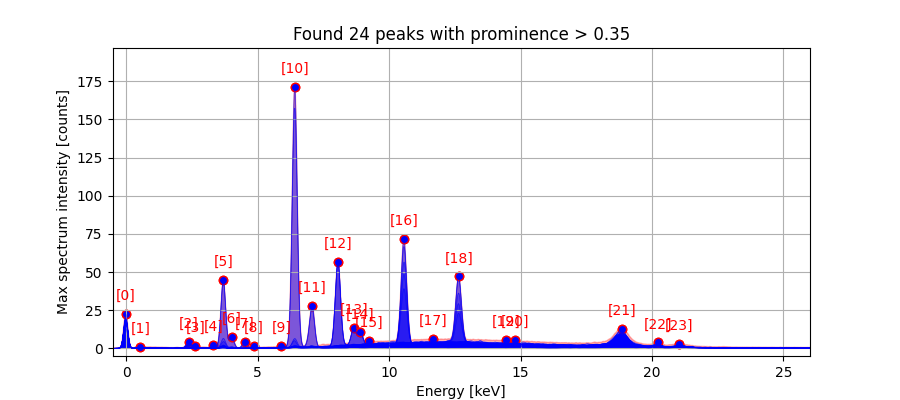

Step 1/3: Reading hot max channel maps...
[########################################] | 100% Completed |  1min 45.6s
Step 2/3: Locating hot max pixels...
Step 3/3: Ready with reading hot max spectra. 
Write hotmax spectra and pixels to datastack file [y/n]? n


In [ ]:
hotmax_pixels, hotmax_spectra = get_hotmax('RP-T-1898-A-3689.datastack')

In further analysis our stored hotmax pixel indexes and hotmax spectra can now be accessed using the `DataStack.read_hotmax()` method. 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')
hotmax_pixels, hotmax_spectra = ds.read_hotmax()

n_pixels, n_dims = hotmax_pixels.shape
n_spectra, n_channels = hotmax_spectra.shape 

print(f'The array of hotmax pixels contains {n_pixels} pixels. ')
print(f'Each pixel consists of {n_dims} indexes.\n')
print(f'There are {n_spectra} hotmax spectra.')
print(f'Each spectrum contains {n_channels} intensity values.')

The array of hotmax pixels contains 24 pixels. 
Each pixel consists of 3 indexes.

There are 24 hotmax spectra.
Each spectrum contains 4096 intensity values.


Let's pick one of the 24 hotmax spectra and take a closer look by plotting with `matplotlib`. It is interesting to compare this spectrum with the max spectrum envelope. 

<IPython.core.display.Javascript object>


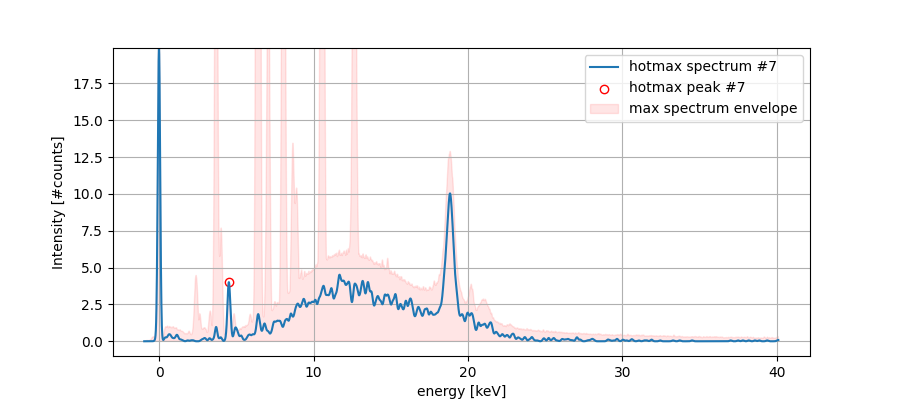

In [ ]:
import matplotlib.pyplot as plt 

ds = DataStack('RP-T-1898-A-3689.datastack')

x_keVs = ds.read_energies()
y_max = ds.read_maxspectrum()
hotmax_pixels, hotmax_spectra = ds.read_hotmax()

n = 7 

y_hot = hotmax_spectra[n]
i = hotmax_pixels[n, 2] # channel index 

fig, ax = plt.subplots(figsize=[9, 4])

ax.plot(x_keVs, y_hot, label=f'hotmax spectrum #{n}')
ax.scatter(x_keVs[i], y_hot[i], edgecolor='r', facecolor='w', label=f'hotmax peak #{7}')
ax.fill_between(x_keVs, y_max, color='r', alpha=0.1, label='max spectrum envelope')
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Intensity [#counts]')
ax.set_ylim(-1, y_hot.max())
ax.grid()
ax.legend();

The measured spectrum consists of a a slowly varying baseline, the so-called the Compton ridge, with peaks added on top. Some of these peaks are caused by x-ray fluorescence of specific chemical elements. Other peaks are just noise. 

The difficulty with these kind of spectra is that the noise level varies with the signal according to Poisson statistics. The variance of noise is linearly proportional to the signal level. For this reason, we observe more noise on top of the Compton ridge. 

In order to distinguish significant peaks from noise it is possible to estimate a baseline with a noise envelope for a given spectrum with the `get_baseline()` and `get_noiseline()`functions. The algorithm used in the baseline function is the rolling ball filter. In accordance with Poisson statistics, the noise level is estimated as a square root function of the baseline level. 

In [ ]:
import maxrf4u 
import scipy.signal as ssg 
import numpy as np 
#from maxrf4u import get_baseline, get_noiseline 



#ds = DataStack('RP-T-1898-A-3689.datastack')

class HotmaxAtlas(): 
    
    def __init__(self, datastack_file, prominence=0.2): 
        
        self.datastack_file = datastack_file 
        
        ds = maxrf4u.DataStack(self.datastack_file)
        
        self.x_keVs = ds.read_energies() 
        self.y_max = ds.read_maxspectrum()
        
        self.hotmax_pixels, self.hotmax_spectra = ds.read_hotmax() 
        self.n_spectra = len(self.hotmax_spectra) 
        
        self.hotspectrum_list = []
        self.baseline_list = []
        self.noiseline_list = []
        self.peak_idxs_list = [] 
        
        for i, y_hot in enumerate(self.hotmax_spectra): 
            
            print(f'Analyzing noise envelope for spectrum {i}/{self.n_spectra - 1}...', end='\r')
            
            # noise envelope 
            baseline = maxrf4u.get_baseline(self.x_keVs, y_hot)
            self.baseline_list.append(baseline)
            
            noiseline = maxrf4u.get_noiseline(baseline)
            self.noiseline_list.append(noiseline)

            # subpeaks (=lines)  
            above_noise = y_hot - noiseline 
            above_noise[y_hot < noiseline] = 0 
            peak_idxs, _ = ssg.find_peaks(above_noise, prominence=prominence) 
            self.peak_idxs_list.append(peak_idxs)  
        
        # collect all lines in single list 
        self.all_peaks = []
        for peak_idxs in self.peak_idxs_list: 
            for i in peak_idxs: 
                self.all_peaks.append(i)

        self.all_peaks_set = np.sort(list(set(self.all_peaks))) 
        
    def plot_spectrum(self, n, ax=None): 
        
        if ax is None: 

            fig, ax = plt.subplots(figsize=[10, 3])

        x_keVs = self.x_keVs 
        y_max = self.y_max
        y_hot = self.hotmax_spectra[n] 
        ci = self.hotmax_pixels[n][2]

        ylim = 1.05 * y_hot.max()

        max_peak_indices = hma.hotmax_pixels[:,2]
        max_peak_keVs = x_keVs[max_peak_indices] 

        baseline = hma.baseline_list[n]
        noiseline = hma.noiseline_list[n] 

        peak_indices = hma.peak_idxs_list[n]

        ax.plot(x_keVs, y_hot, zorder=15, label=f'hotmax spectrum #{n}')
        ax.scatter(x_keVs[ci], y_hot[ci], marker='s', zorder=25, edgecolor='r', 
                   facecolor='w', label=f'hotmax peak #{n}')
        ax.fill_between(x_keVs, y_max, color='r', alpha=0.2, zorder=8, label='max spectrum')

        ax.fill_between(x_keVs, baseline, noiseline, color=[0.5, 0.5, 0.9], zorder=10, alpha=0.4, label='noise envelope')

        ax.scatter(x_keVs[peak_indices], y_hot[peak_indices], edgecolor='b', zorder=20, facecolor='w')

        ax.set_xlabel('energy [keV]')
        ax.set_ylabel('Intensity [#counts]')
        ax.set_ylim(-1, ylim)
        ax.set_xlim(-1, 30)
        ax.vlines(max_peak_keVs, ymin=0, ymax=ylim, color='r', alpha=0.3)
        ax.legend() 
        
        if ax is None: 
            plt.tight_layout()
        
        
 

In [ ]:
def plot_spectra(hotmax_atlas):
    
    self = hotmax_atlas 

    fig, axs = plt.subplots(nrows=self.n_spectra, figsize=[9, 1.7*self.n_spectra], sharex=True)

    for n in range(self.n_spectra): 

        self.plot_spectrum(n, ax=axs[n])

    plt.tight_layout()
    
        
        

In [ ]:
hma = HotmaxAtlas('RP-T-1898-A-3689.datastack', prominence=2) #0.1)

<IPython.core.display.Javascript object>


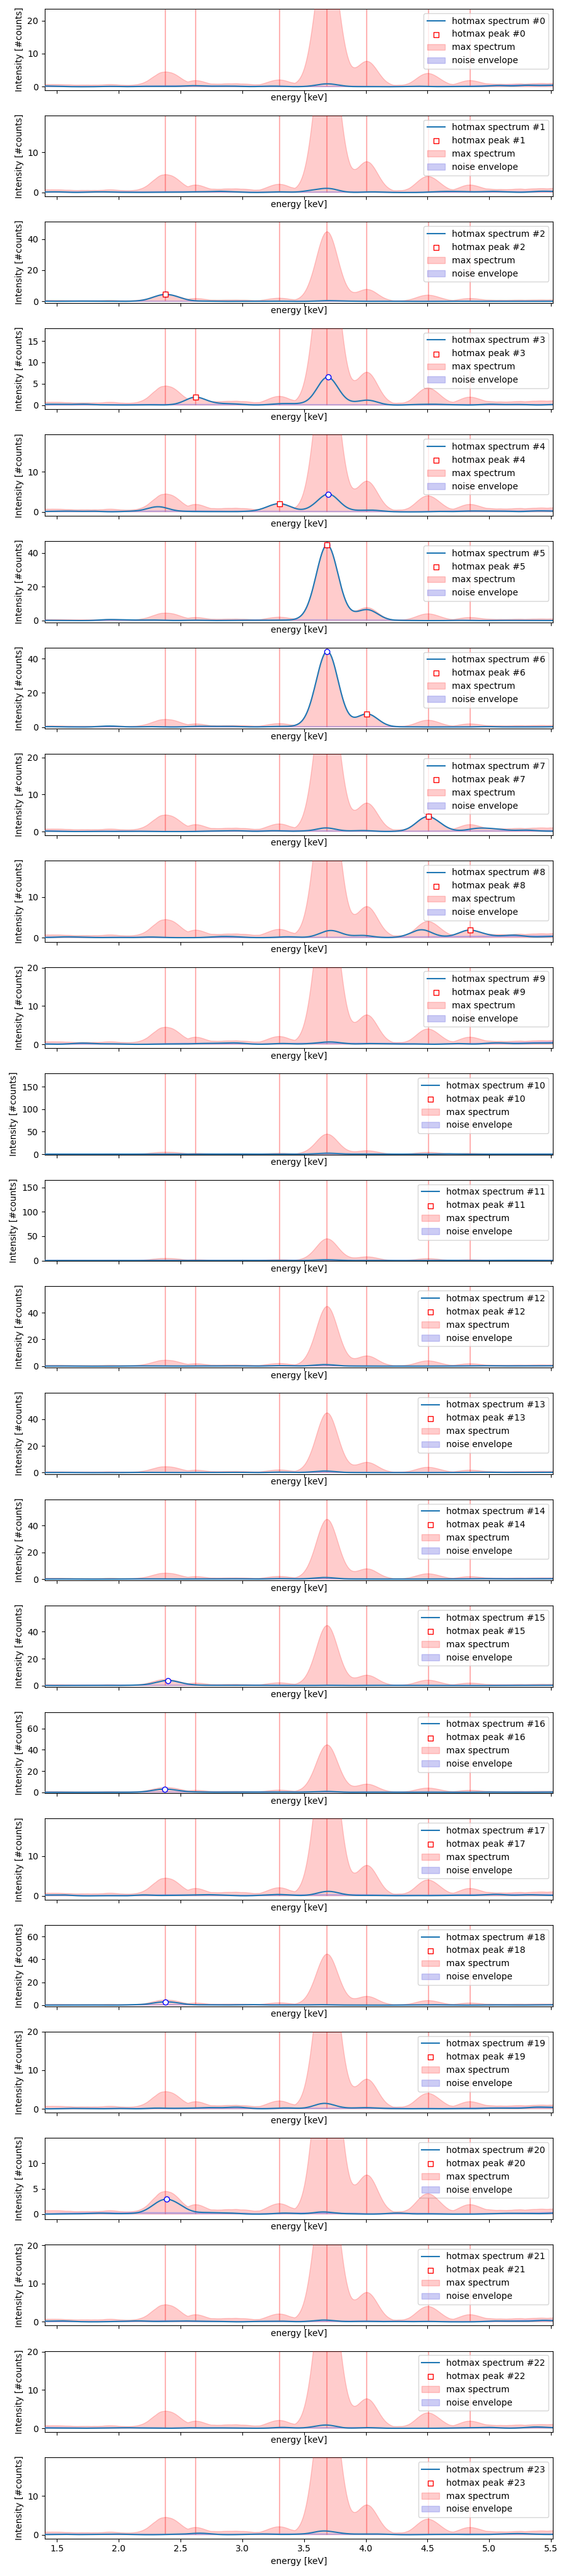

In [ ]:
plot_spectra(hma)

<IPython.core.display.Javascript object>


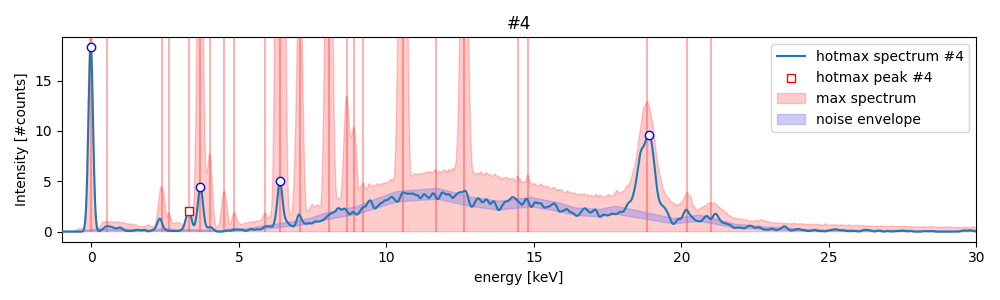

<AxesSubplot:title={'center':'#4'}, xlabel='energy [keV]', ylabel='Intensity [#counts]'>

In [ ]:
hma.plot_spectrum(4)

In [ ]:
hma.plot_spectra()

TypeError: __init__() got an unexpected keyword argument 'nrows'

<IPython.core.display.Javascript object>


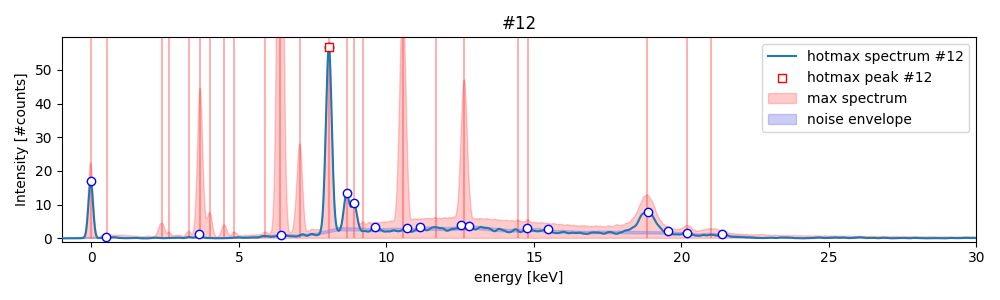

In [ ]:
hma.plot_spectrum(12);

In [ ]:
len(hma.all_peaks)

334

In [ ]:
hma.hotmax_pixels[:,2]

array([  95,  151,  335,  359,  427,  465,  497,  547,  581,  685,  736,
        802,  900,  960,  984, 1017, 1150, 1261, 1358, 1539, 1573, 1976,
       2112, 2192])

<IPython.core.display.Javascript object>


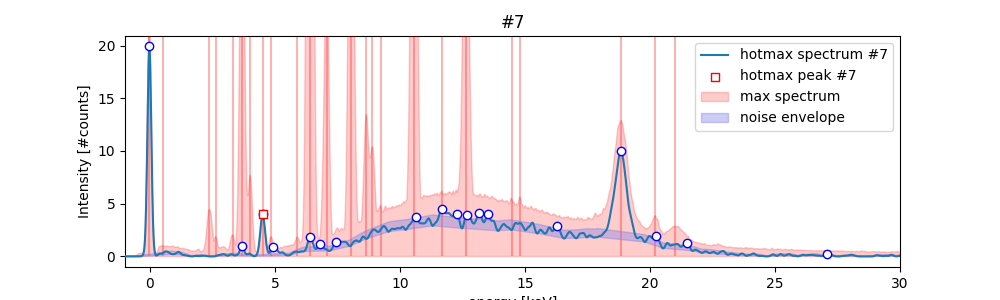

In [ ]:
def 

fig, ax = plt.subplots(figsize=[10, 3])

n = 7

x_keVs = hma.x_keVs 
y_max = hma.y_max
y_hot = hma.hotmax_spectra[n] 
ci = hma.hotmax_pixels[n][2]

ylim = 1.05 * y_hot.max()

max_peak_indices = hma.hotmax_pixels[:,2]
max_peak_keVs = x_keVs[max_peak_indices] 

baseline = hma.baseline_list[n]
noiseline = hma.noiseline_list[n] 

peak_indices = hma.peak_idxs_list[n]


ax.set_title(f'#{n}')
ax.plot(x_keVs, y_hot, zorder=15, label=f'hotmax spectrum #{n}')
ax.scatter(x_keVs[ci], y_hot[ci], marker='s', zorder=25, edgecolor='r', facecolor='w', label=f'hotmax peak #{n}')
ax.fill_between(x_keVs, y_max, color='r', alpha=0.2, zorder=8, label='max spectrum')

ax.fill_between(x_keVs, baseline, noiseline, color=[0.5, 0.5, 0.9], zorder=10, alpha=0.4, label='noise envelope')

ax.scatter(x_keVs[peak_indices], y_hot[peak_indices], edgecolor='b', zorder=20, facecolor='w')

ax.set_xlabel('energy [keV]')
ax.set_ylabel('Intensity [#counts]')
ax.set_ylim(-1, ylim)
ax.set_xlim(-1, 30)
ax.vlines(max_peak_keVs, ymin=0, ymax=ylim, color='r', alpha=0.3)
ax.legend();



The result is not perfect, but most of the noise peaks do not exceed the noise envelope. 

### `maxrf4u.hotmax.py`

In [ ]:
%%writefile /home/frank/Work/Projecten/DoRe/code/maxrf4u/hotmax.py 

# See development notebook: ~/Work/Projecten/DoRe/notebooks/2021-03-05-maxrf4u-dev.ipynb 

import maxrf4u 
import scipy.signal as ssg 
import numpy as np 
import time 
import matplotlib.pyplot as plt 
from dask.diagnostics import ProgressBar 
import scipy.ndimage.morphology as morph 
import scipy.interpolate as sip 


def get_hotmax(datastack_file, prominence=0.35): 
    '''Collect hotmax pixels and corresponding spectra from *datastack_file*. 
    
    Ask user confirmation for saving result to datastack file. 
    '''
   
    # read max spectrum 
    ds = maxrf4u.DataStack(datastack_file)
    x_keVs = ds.read_energies()
    y_max = ds.read_maxspectrum()

    # locate max spectrum peaks in max spectrum 
    peak_indices, _ = ssg.find_peaks(y_max, prominence=prominence)
    peaks_x = x_keVs[peak_indices]
    peaks_y = y_max[peak_indices]
    
    # plot max spectrum with peaks 
    
    plt.close('all')
    
    plt.ion() # important for updating plots with fig.canvas.draw() 
    
    fig, ax = plt.subplots(figsize=[9, 4])

    fig.canvas.draw()   
    ax.fill_between(x_keVs, y_max, color='r', alpha=0.3)
    ax.scatter(peaks_x, peaks_y, facecolor='w', edgecolor='r')  
    ax.set_xlim(peaks_x[0] - 0.5, peaks_x[-1] + 5) 
    ax.set_ylim(-5, 1.15 * np.max(peaks_y))
    
    plt.pause(0.3) 
    fig.canvas.draw() 
    fig.canvas.flush_events()
    

    for i, peak_xy in enumerate(zip(peaks_x, peaks_y)): 
        ax.annotate(f'[{i}]', peak_xy, xytext=[0, 10], color='r', 
                        textcoords='offset points', ha='center')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel('Max spectrum intensity [counts]')
    ax.set_title(f'Found {len(peak_indices)} peaks with prominence > {prominence}')
    ax.grid()

    plt.pause(0.3) 
    fig.canvas.draw() 
    fig.canvas.flush_events()
 
    
    # read corresponding channel maps for all max peak indices 
    print('Step 1/3: Reading hot max channel maps...')
    with ProgressBar(): 
        channel_maps = ds.maxrf_cube[:,:,peak_indices].compute() 

    channel_maps = channel_maps.transpose([2, 0, 1])

    # locate hot max pixels in channel maps 
    print('Step 2/3: Locating hot max pixels...')
    hot_pixels = []
    for k, c_map in enumerate(channel_maps): 
        hot_i, hot_j = np.argwhere(c_map == peaks_y[k]).flatten()
        hot_pixels.append([hot_i, hot_j, peak_indices[k]])

    hot_pixels = np.array(hot_pixels)    

    # read spectrum for each hot max pixel  
    hot_spectra = [] 
    for n, [i, j, _] in enumerate(hot_pixels):
        print(f'Step 3/3: Reading hot max spectrum {n}/{len(hot_pixels) - 1}...', end='\r')
        spectrum = ds.maxrf_cube[i,j,:].compute()
        hot_spectra.append(spectrum)
        
        ax.plot(x_keVs, spectrum, color='b', linewidth=0.5, alpha=0.5) 
        ax.fill_between(x_keVs, spectrum, color='b', linewidth=0.5, alpha=0.3) 
        ax.scatter(peaks_x[n], peaks_y[n], facecolor='b', edgecolor='r') 

        # force updating plot 
        plt.pause(0.2) 
        fig.canvas.draw()
        fig.canvas.flush_events()
        
    print(f'Step 3/3: Ready with reading hot max spectra. ')

    hot_spectra = np.array(hot_spectra)  
    
    # user input           
    write = input('Write hotmax spectra and pixels to datastack file [y/n]? ')
         
    if write == 'y': 
        maxrf4u.append(hot_spectra, maxrf4u.HOTMAX_SPECTRA, ds.datastack_file)
        maxrf4u.append(hot_pixels, maxrf4u.HOTMAX_PIXELS, ds.datastack_file) 

        print(f'\nSaved hotmax data to: {ds.datastack_file}')
        
    # force updating plot 
    plt.pause(0.3) 
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    return hot_pixels, hot_spectra 
    


def get_baseline(x_keVs, spectrum, radius=200, return_indices=False): 
    '''Calculate rolling ball baseline for *spectrum*.  
    
    Uses distance map to select only the lowest surges that touch the rolling ball.'''

    spectrum_norm = spectrum / spectrum.max()
    
    w = len(spectrum) 
    h = w // 2

    # initialize ramp with normalized spectrum in top half  
    ramp = np.ones([h, w]) * np.linspace(1, -1, h)[:, None]
    
    # create boolean mask from spectrum 
    spectrum_mask = ramp < spectrum_norm 
    
    # create distance map for spectrum mask. 
    dist_map, index_images = morph.distance_transform_edt(spectrum_mask, return_indices=True)

    # we only need the second (x-axis) channel index image
    _, index_img = index_images 

    # roll the ball 
    ball_mask = dist_map < radius 
    ball_profile = ball_mask.sum(axis=0) 

    # get touching surges indices 
    lowest_indices = list(set(index_img[ball_profile, range(w)]))
    
    # create linear interpolation between the selected lowest surges (valleys)
    interpolation = sip.interp1d(x_keVs[lowest_indices], spectrum[lowest_indices], bounds_error=False)
    baseline = interpolation(x_keVs) 
    
    # valley indices 
    if return_indices: 
        return baseline, lowest_indices 
    
    return baseline 

def get_noiseline(baseline, alpha=0.6, beta=0.1): 
    '''Estimate Poisson noise line from *baseline*. '''
    
    noiseline = baseline + alpha * np.sqrt(baseline + beta**2)
    
    return noiseline 

def get_envelopes(spectra, radius=200, alpha=0.6, beta=0.1, return_lowest=False): 
    '''Utility function to get baselines and noiselines from *spectra*. '''
      
    baseline_spectra = []  
    lowest_indices_list = []
    noiseline_spectra = []
    
    
    for i, spectrum in enumerate(spectra): 
        print(f'Calculating envelope for spectrum {i+1}/{len(spectra)}...', end='\r')
        baseline, lowest_indices = get_baseline(spectrum, radius=radius, return_indices=True)
        baseline_spectra.append(baseline)
        lowest_indices_list.append(sorted(lowest_indices)) # not clear why not sorted? 
        
        noiseline = get_noiseline(baseline, alpha=alpha, beta=beta) 
        noiseline_spectra.append(noiseline)
        
    if return_indices: 
        return baseline_spectra, noiseline_spectra, lowest_indices_list
    
    return baseline_spectra, noiseline_spectra 


Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/hotmax.py


In [ ]:
# force deep reload 
import maxrf4u
import sys 

del sys.modules['maxrf4u.storage']
del sys.modules['maxrf4u.calibration']
del sys.modules['maxrf4u.hotmax']
del sys.modules['maxrf4u']

import maxrf4u

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 

In [ ]:
ds = maxrf4u.DataStack('RP-T-1898-A-3689.datastack')

In [ ]:
x_keVs = ds.energies()
y_max = ds.maxspectrum()

In [ ]:
hot_spectra, hot_pixels = maxrf4u.hotmax_spectra('RP-T-1898-A-3689.datastack')

Reading hot max channel maps...
[########################################] | 100% Completed | 48.8s
Locating hot max pixels...


In [ ]:
pixels[:,2]

array([  95,  151,  335,  359,  427,  465,  497,  547,  581,  685,  736,
        802,  900,  960,  984, 1017, 1150, 1261, 1358, 1539, 1573, 1976,
       2112, 2192])

In [ ]:
spectra.shape

(24, 4096)

In [ ]:
%matplotlib notebook

<IPython.core.display.Javascript object>


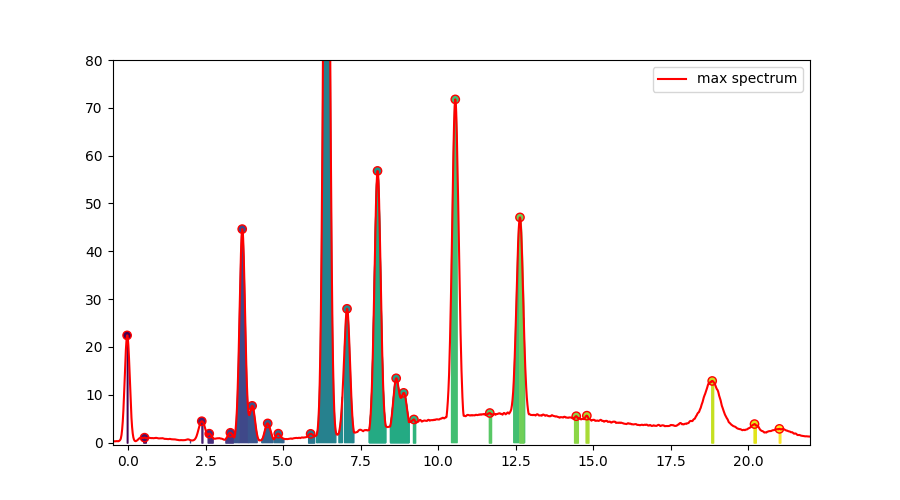

(-0.5, 80.0)

In [ ]:
colors = cm.viridis(np.linspace(0, 1, len(spectra)))

fig, ax = plt.subplots(figsize=[9, 5])

[ax.fill_between(x_keVs, s, where=(s==y_max), color=c) for s, c in zip(spectra, colors)];
ax.plot(x_keVs, y_max, color='r', label='max spectrum')
ax.scatter(x_keVs[pixels[:,2]], y_max[pixels[:,2]], facecolor=colors, edgecolor='r')

ax.legend()
ax.set_xlim(-0.5, 22)
ax.set_ylim(-0.5, 80)

In [ ]:
maxrf4u.append(hot_spectra, maxrf4u.MAXRF_HOT_SPECTRA, ds.datastack_file)

In [ ]:
maxrf4u.append(hot_pixels, maxrf4u.MAXRF_HOT_PIXELS, ds.datastack_file)

In [ ]:
maxrf4u.tree('RP-T-1898-A-3689.datastack')

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_energies (4096,) float64
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


In [ ]:
ds.maxrf_hot_pixels.compute()

array([[ 546, 1155],
       [ 805,  204],
       [ 951,  409],
       [ 840,   22],
       [ 853,  803],
       [ 793,  908],
       [ 793,  909],
       [1666,  925],
       [ 124,   51],
       [1294,  862],
       [ 657,  327],
       [1425,   32],
       [ 489,  122],
       [ 489,  122],
       [ 489,  122],
       [ 889,  280],
       [ 891,  216],
       [ 474,  181],
       [ 890,  217],
       [ 883,  636],
       [ 933,  297],
       [1520,  412],
       [1604,  487],
       [1661,  797]])

### Hot pixels 

For each peak in the max spectrum it is informative to inspect the corresponding spectrum.  

In [ ]:
import maxrf4u 
from skimage import exposure 
import numpy as np 
from dask.diagnostics import ProgressBar 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import scipy.ndimage.morphology as morphology 
import scipy.interpolate as sip
import moseley as mos 
import scipy.signal as ssg 
import skimage.measure as skm

In [ ]:
# read max spectrum from file 
ds = maxrf4u.DataStack('RP-T-1898-A-3689.datastack')

x_keVs = ds.energies()
y_max = ds.max_spectrum()

In [ ]:
# locate max spectrum peaks  
peak_indices, _ = ssg.find_peaks(y_max, prominence=0.35)
peaks_y = y_max[peak_indices]

# collect channel maps for all max peak indices 
print('Reading hot max channel maps...')
with ProgressBar(): 
    channel_maps = ds.maxrf_cube[:,:,peak_indices].compute() 
    
channel_maps = channel_maps.transpose([2, 0, 1])

# locate hot max pixels 
print('Locating hot max pixels...')
hot_pixels = []
for i, m in enumerate(channel_maps): 
    px = np.argwhere(m == peaks_y[i]).flatten()
    hot_pixels.append(px)

hot_pixels = np.array(hot_pixels)
hot_i, hot_j = hot_pixels.T

# read spectrum for each hot max pixel  
hot_spectra = [] 
for n, [i, j] in enumerate(hot_pixels):
    print(f'Reading hot max spectrum {n}/{len(hot_pixels) - 1}...', end='\r')
    spectrum = ds.maxrf_cube[i,j,:].compute()
    hot_spectra.append(spectrum)

array([ 22.420197 ,   1.0366088,   4.471294 ,   1.8675518,   2.053187 ,
        44.639946 ,   7.688075 ,   4.014601 ,   1.8734547,   1.8358387,
       171.1319   ,  27.97701  ,  56.811874 ,  13.447386 ,  10.40261  ,
         4.8390064,  71.76492  ,   6.1887264,  47.094486 ,   5.521645 ,
         5.632422 ,  12.891043 ,   3.8758206,   2.87181  ], dtype=float32)

In [ ]:
# locate max spectrum peaks 
peaks_xy, slices = maxrf4u.get_slices(x_keVs, y_max, prominence=0.35)

In [ ]:
peaks_y = peaks_xy[:,1]
peak_indices = slices[:,1]

# collect channel maps for all max peak indices 
print('Reading hot max channel maps...')
with ProgressBar(): 
    channel_maps = ds.maxrf_cube[:,:,peak_indices].compute() 
    
channel_maps = channel_maps.transpose([2, 0, 1])

# locate hot max pixels 
print('Locating hot max pixels...')
hot_pixels = []
for i, m in enumerate(channel_maps): 
    px = np.argwhere(m == peaks_y[i]).flatten()
    hot_pixels.append(px)

hot_pixels = np.array(hot_pixels)
hot_i, hot_j = hot_pixels.T

# read spectrum for each hot max pixel  
hot_spectra = [] 
for n, [i, j] in enumerate(hot_pixels):
    print(f'Reading hot max spectrum {n}/{len(hot_pixels) - 1}...', end='\r')
    spectrum = ds.maxrf_cube[i,j,:].compute()
    hot_spectra.append(spectrum)
    

Reading hot max channel maps...
[########################################] | 100% Completed | 51.3s
Locating hot max pixels...


In [ ]:
# create FeKa peak map 
IRON_Ka_index = np.argwhere(x_keVs == maxrf4u.IRON_Ka)[0, 0]

with ProgressBar(): 
    map_FeKa = ds.maxrf_cube[:,:, IRON_Ka_index].compute()
    
map_FeKa_histeq = exposure.equalize_hist(map_FeKa)

[########################################] | 100% Completed |  5.5s


In [ ]:
colors = cm.tab20(np.arange(len(hot_pixels)) % 20)

<IPython.core.display.Javascript object>


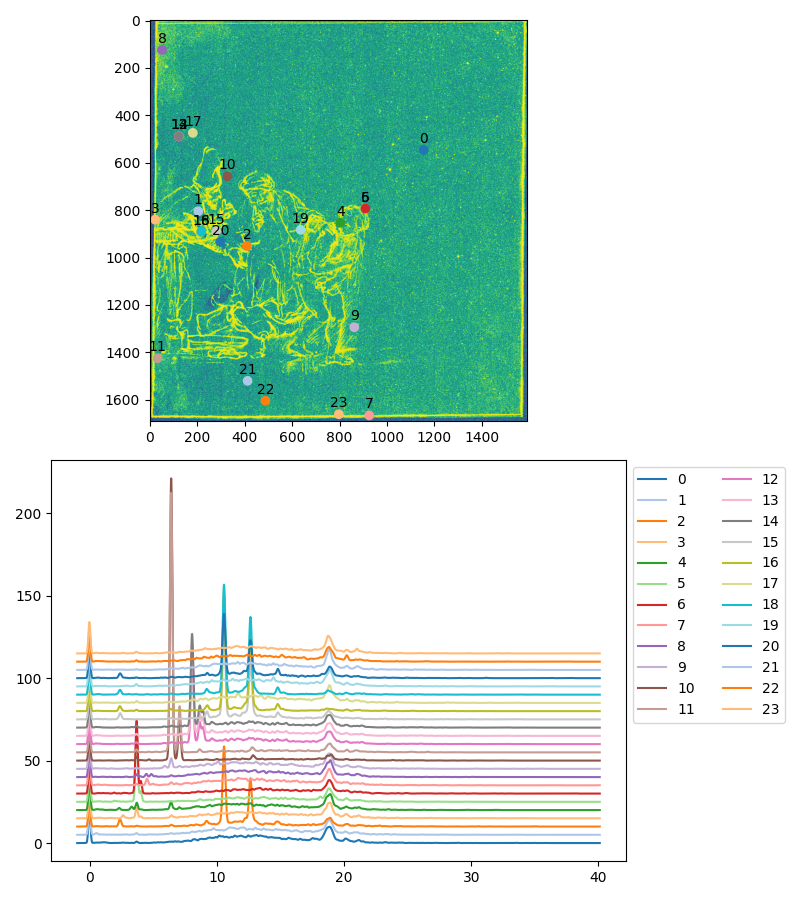

In [ ]:
fig, [ax, ax1] = plt.subplots(nrows=2, figsize=[8, 9])
ax.imshow(map_FeKa_histeq)
ax.scatter(hot_j, hot_i, color=colors)

for i, xy in enumerate(hot_pixels):  
    ax.annotate(f'{i}', xy[::-1], xytext=[0, 5], textcoords='offset points', ha='center')
    
step = 5
for i, spectrum in enumerate(hot_spectra): 
    ax1.plot(x_keVs, spectrum + i * step, label=i, color=colors[i])
    
ax1.legend(loc='upper left', ncol=2, bbox_to_anchor=(1, 1))

plt.tight_layout()

Ok, we need to subtract the baseline signals and normalize against baseline Poisson standard deviation to locate significant peaks.  

In [ ]:
def get_baseline(spectrum, radius=200, return_indices=False): 
    '''Calculate rolling ball baseline for *spectrum*.  
    
    Uses distance map to select only the lowest surges that touch the rolling ball.'''

    spectrum_norm = spectrum / spectrum.max()
    
    w = len(spectrum) 
    h = w // 2

    # initialize ramp with normalized spectrum in top half  
    ramp = np.ones([h, w]) * np.linspace(1, -1, h)[:, None]
    
    # create boolean mask from spectrum 
    spectrum_mask = ramp < spectrum_norm 
    
    # create distance map for spectrum mask 
    dist_map, index_images = morphology.distance_transform_edt(spectrum_mask, return_indices=True)

    # we only need the second (x-axis) channel index image
    _, index_img = index_images 

    # roll the ball 
    ball_mask = dist_map < radius 
    ball_profile = ball_mask.sum(axis=0) 

    # get touching surges indices 
    lowest_indices = list(set(index_img[ball_profile, range(w)]))
    
    # create linear interpolation between the selected lowest surges (valleys)
    interpolation = sip.interp1d(x_keVs[lowest_indices], spectrum[lowest_indices], bounds_error=False)
    baseline = interpolation(x_keVs) 
    
    # valley indices 
    if return_indices: 
        return baseline, lowest_indices 
    
    return baseline 

In [ ]:
def get_noiseline(baseline, alpha=0.6, beta=0.1): 
    '''Estimate Poisson noise line from *baseline*. '''
    
    noiseline = baseline + alpha * np.sqrt(baseline + beta**2)
    
    return noiseline 

In [ ]:
def get_envelopes(spectra, radius=200, alpha=0.6, beta=0.1, return_lowest=False): 
    '''Utility function to get baselines and noiselines from *spectra*. '''
      
    baseline_spectra = []  
    lowest_indices_list = []
    noiseline_spectra = []
    
    
    for i, spectrum in enumerate(spectra): 
        print(f'Calculating envelope for spectrum {i+1}/{len(spectra)}...', end='\r')
        baseline, lowest_indices = get_baseline(spectrum, radius=radius, return_indices=True)
        baseline_spectra.append(baseline)
        lowest_indices_list.append(sorted(lowest_indices)) # not clear why not sorted? 
        
        noiseline = get_noiseline(baseline, alpha=alpha, beta=beta) 
        noiseline_spectra.append(noiseline)
        
    if return_indices: 
        return baseline_spectra, noiseline_spectra, lowest_indices_list
    
    return baseline_spectra, noiseline_spectra 


In [ ]:
baseline_spectra, noiseline_spectra, lowest_indices_list = get_envelopes(hot_spectra, return_indices=True)

Let's explore for a single spectrum first...

In [ ]:
i = 0 
y = hot_spectra[i]
b = baseline_spectra[i]
n = noiseline_spectra[i] 
l = lowest_indices_list[i]

is_lowest = np.zeros_like(y, dtype=int)
is_lowest[l] = 1 
# make sure endpoints are surges  
is_lowest[0] = 1
is_lowest[-1] = 1

# label all regions between lowest surges 
is_region = 1 - is_lowest 

region_labeled = skm.label(is_region) 
region_labels = list(set(region_labeled)) 
region_labels = region_labels[1:] # exclude zero bg

above_noise = y - n 
above_noise[y < n] = 0 

hot_peak_indices, hot_peak_props = ssg.find_peaks(above_noise, prominence=0.2)

is_peak = np.zeros_like(y, dtype=int)
is_peak[hot_peak_indices] = 1 

# now collect all peak regions  

is_ridge = np.zeros_like(y, dtype=int)

for rl in region_labels: 
    
    is_region = region_labeled == rl
    is_peak_in_region = is_peak * is_region 
    peak_count = np.sum(is_peak_in_region)
    
    if peak_count > 0: 
        is_ridge = is_ridge + is_region 


<IPython.core.display.Javascript object>


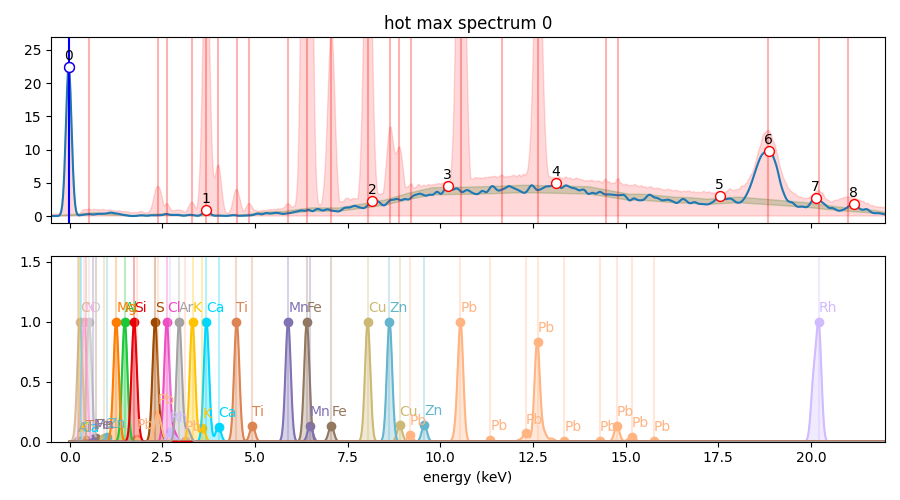

(-1.1210098266601562, 26.90423583984375)

In [ ]:
fig, [ax, ax1] = plt.subplots(nrows=2, sharex=True, figsize=[9, 5])

#tax = ax.twinx()

ax.plot(x_keVs, y)
ax.scatter(x_keVs[hot_peak_indices], y[hot_peak_indices], 
           edgecolor='r', facecolor='w', marker='o', s=50, zorder=20)

[ax.annotate(f'{j}', xy, xytext=[0, 5], 
             textcoords='offset points', ha='center') for j, xy in 
             enumerate(zip(x_keVs[hot_peak_indices], y[hot_peak_indices]))]

ax.scatter(peaks_xy[i, 0], peaks_xy[i, 1], 
           edgecolor='b', facecolor='w', marker='o', s=50, zorder=20)

ax.set_title(f'hot max spectrum {i}')
ax.fill_between(x_keVs, b, n, color='g', alpha=0.2)
[ax.axvline(x, alpha=0.3, color='r') for x in peaks_xy.T[0]]

ax.axvline(peaks_xy[i, 0], color='b')
ax.fill_between(x_keVs, y_max, color='r', alpha=0.15)

#tax.fill_between(x_keVs, is_ridge, color='grey', alpha=0.2)

elements = ['O', 'N', 'C', 'Cl', 'Ca', 'K', 'S', 'Ti', 'Fe', 'Cu', 'Zn', 'Pb', 'Rh', 'Mn', 'Al', 'Mg', 'Si', 'Ar'] 
#elements = ['S'] #, 'Pb']
[mos.XFluo(elem, tube_keV=40).plot(ax=ax1, peak_labels='simple') for elem in elements]
ax1.set_ylim(0, 1.55)
ax.set_xlim(-0.5, 22)
ax.set_ylim(-0.05 * y.max(), 1.2 * y.max())

In [ ]:
hot_peaks_x = x_keVs[hot_peak_indices]
hot_peaks_x[3] - hot_peaks_x[1]

1.7659992787091214

We need to find the connected regions with peaks above the noise line. 

<IPython.core.display.Javascript object>


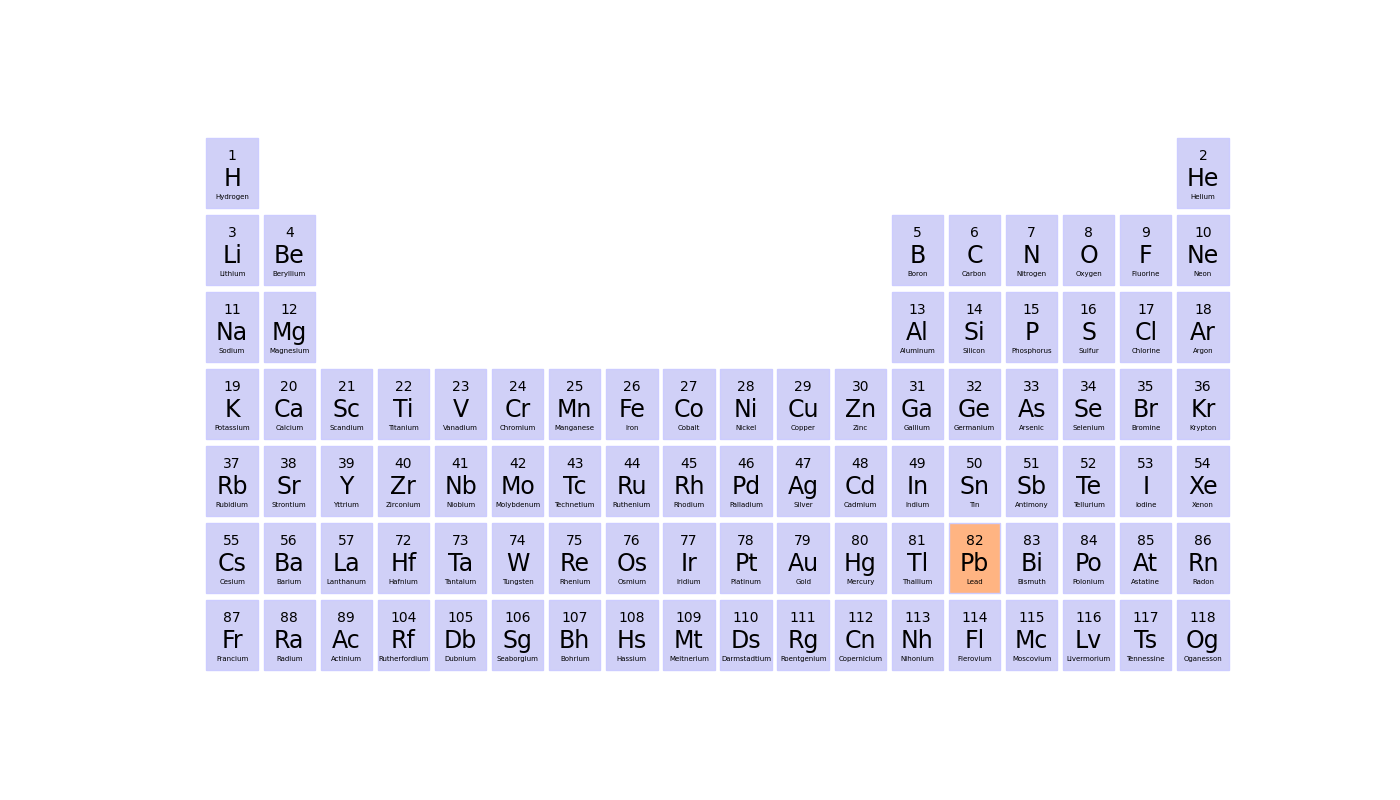

In [ ]:
mos.ptable_plot(['Pb'])

<IPython.core.display.Javascript object>


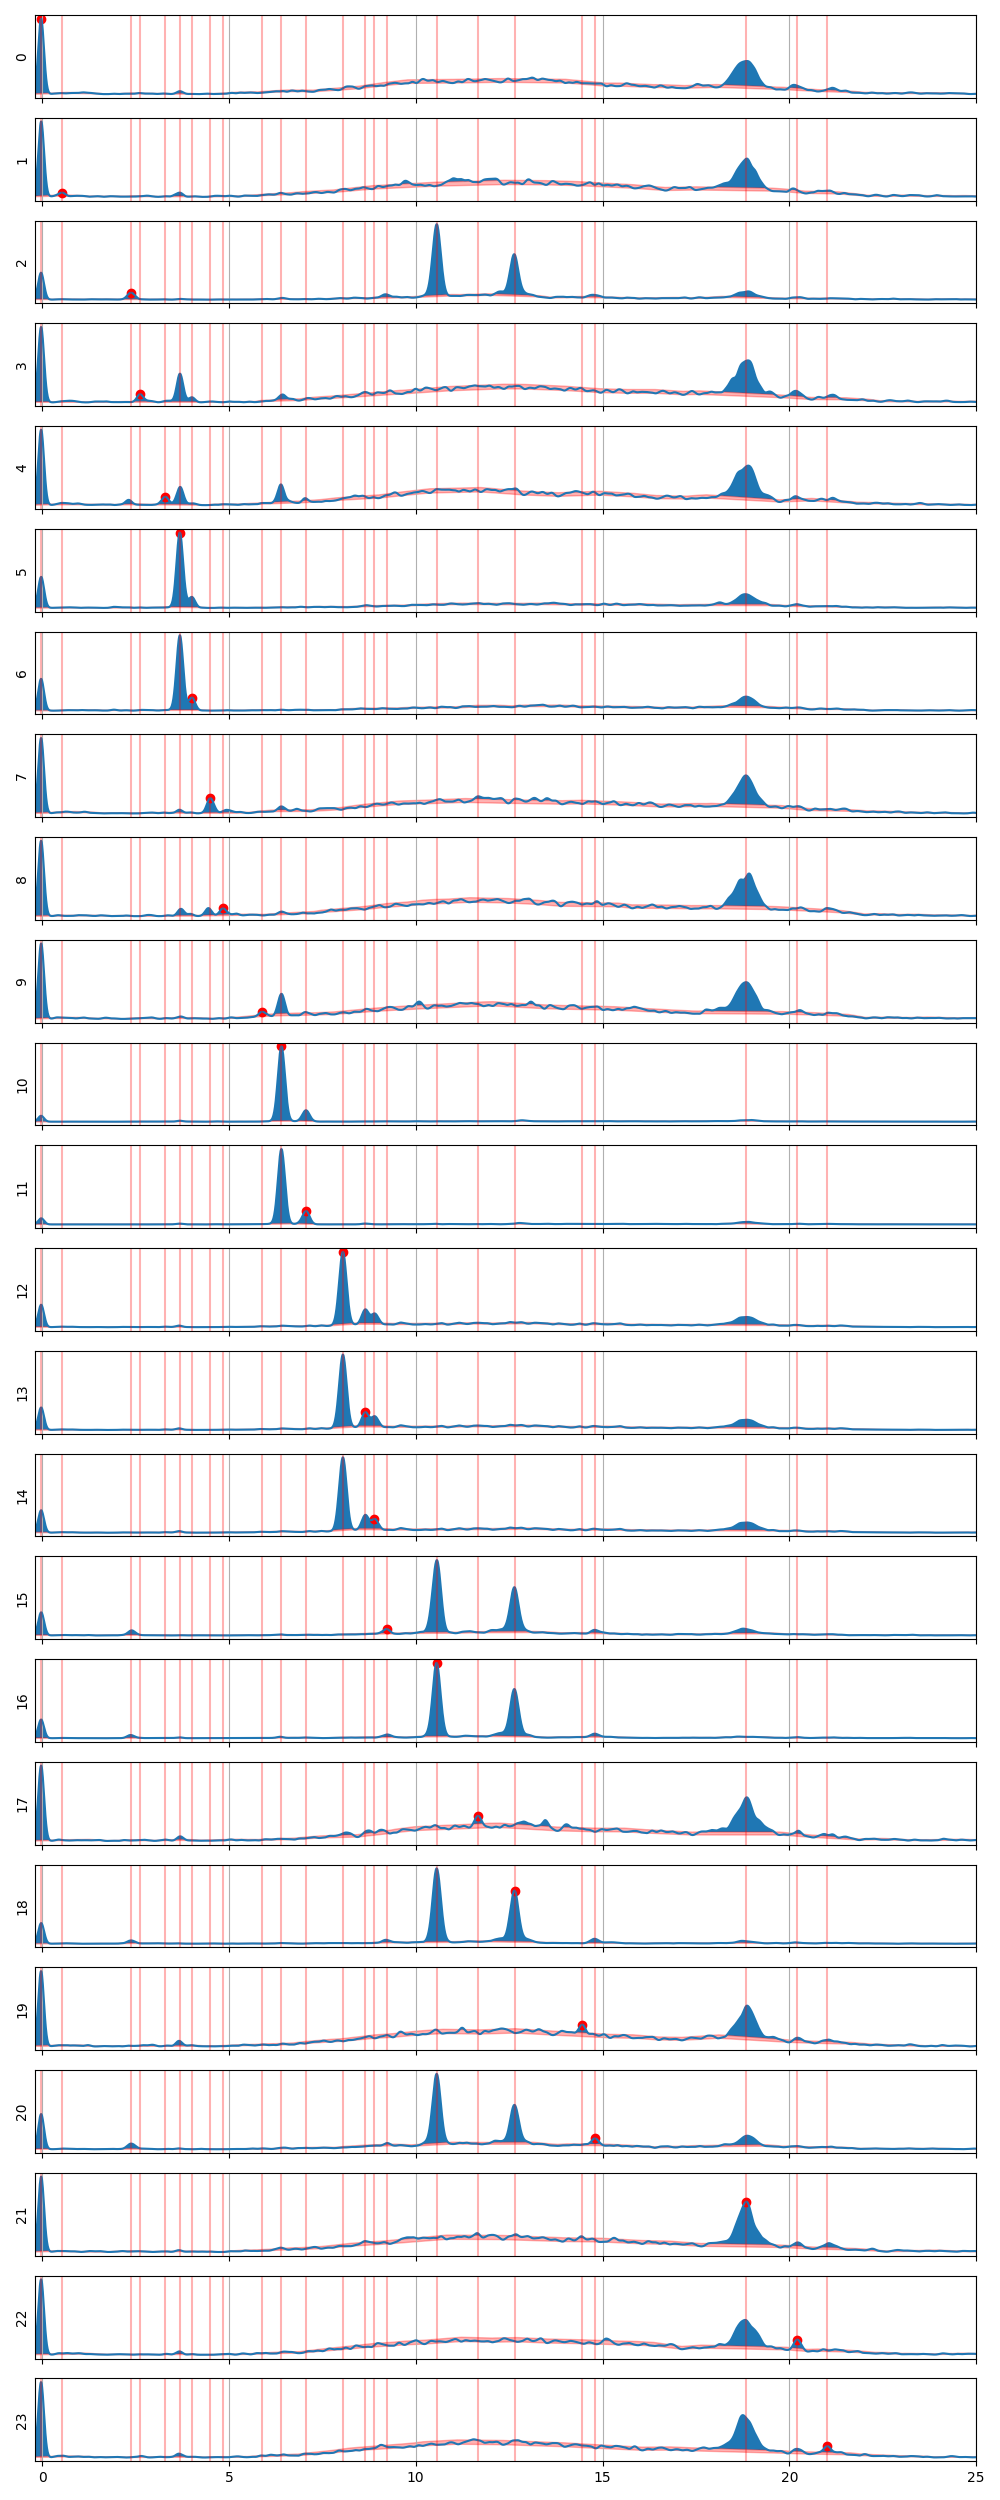

In [ ]:
nrows = len(hot_spectra)
fig, axs = plt.subplots(nrows=nrows, figsize=[10, 25], sharex=True, sharey=False)

for i, [spectrum, baseline, noiseline] in enumerate(zip(hot_spectra, baseline_spectra, noiseline_spectra)): 
    axs[i].fill_between(x_keVs, noiseline, spectrum, spectrum > noiseline)
    #axs[i].plot(x_keVs, spectrum, color='b')
    axs[i].fill_between(x_keVs, noiseline, baseline, color='r', alpha=0.3)
    axs[i].plot(x_keVs, spectrum)
    
    [axs[i].axvline(x, alpha=0.3, color='r') for x in peaks_xy.T[0]]#, ymin=0.0, ymax=100.0, alpha=0.3, color='r')
    axs[i].scatter(peaks_xy[i, 0], peaks_xy[i, 1], color='r')
    axs[i].set_ylabel(i)
    axs[i].set_yticks([])

plt.xlim([-0.2, 25])
plt.tight_layout()

Ok, now we need an alignment table for all peaks in all spectra. 

In [ ]:
j = 4

def plot_noise(j, ax=None): 
    y_j = hot_spectra[j]
    b_j = baseline_spectra[j]
    n_j = noiseline_spectra[j]
    y_flat_j = y_j - b_j 
    
    if ax == None: 
        fig, ax = plt.subplots(figsize=[9, 5])
    
    ax1 = ax.twinx()
    
    mos.XFluo()
    
    ax1.plot(x_keVs, y_max, color='r')
    ax1.set_ylim([-y_max.max(), y_max.max()])
    
    ax.set_ylim(0, 30)
    ax.plot(x_keVs, y_j)
    ax.fill_between(x_keVs, b_j, n_j, color='r', alpha=0.3)
    ax.fill_between(x_keVs, n_j, y_j, y_j > n_j)
    ax.set_ylim(0, 10)
    ax.set_xlim(0, 22)
    ax.set_ylabel(j)
    ax.grid() 
    
    


<IPython.core.display.Javascript object>


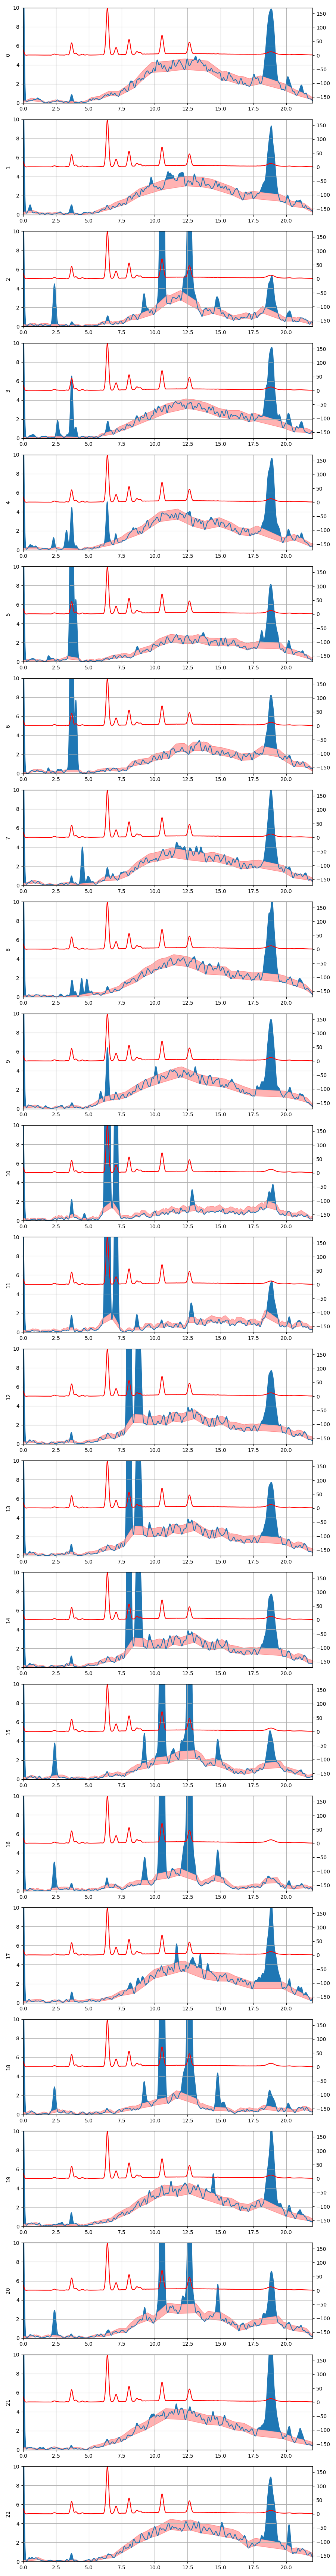

In [ ]:
spectra_indices = range(23) 

nrows = len(spectra_indices)

fig, axs = plt.subplots(nrows=nrows, figsize=[9, 3*nrows])

for i, j in enumerate(spectra_indices):  
    plot_noise(j, ax=axs[i]);

plt.tight_layout()

In [ ]:
hotpeaks_xy, hotslices = maxrf4u.get_slices(x_keVs, y_flat, prominence=0.3)

hotpeak_indices = hotslices[:, 1]

In [ ]:
hotpeak_indices

array([  95,  359,  466,  497,  739, 1981, 2109, 2207])

<IPython.core.display.Javascript object>


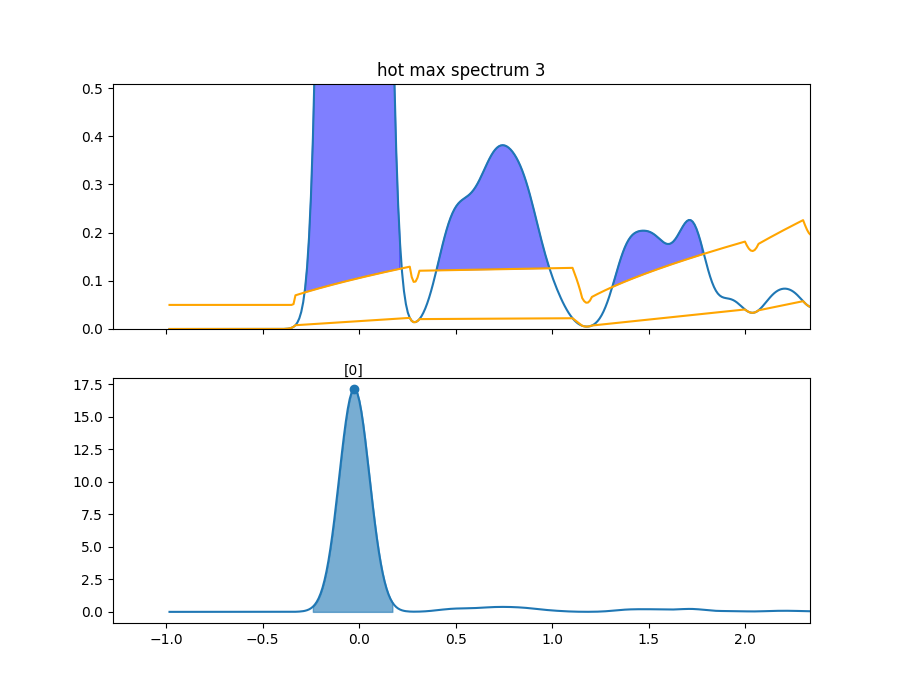

In [ ]:
fig, [ax, ax1] = plt.subplots(nrows=2, sharex=True, figsize=[9, 7])

ax.plot(x_keVs, y) 
ax.plot(x_keVs, b, color='orange')
ax.plot(x_keVs, p, color='orange')
ax.fill_between(x_keVs, p, y, y > p, color='b', alpha=0.5)
ax.set_title(f'hot max spectrum {j}')
ax.set_ylim(0, 25)
ax.scatter(x_keVs[hotpeak_indices], y[hotpeak_indices], color='brown')

maxrf4u.plot_peak_slices(x_keVs, y, ax=ax1);

### TILL HERE pit bumps...

Mm, need to clean up the little bumps...

<IPython.core.display.Javascript object>


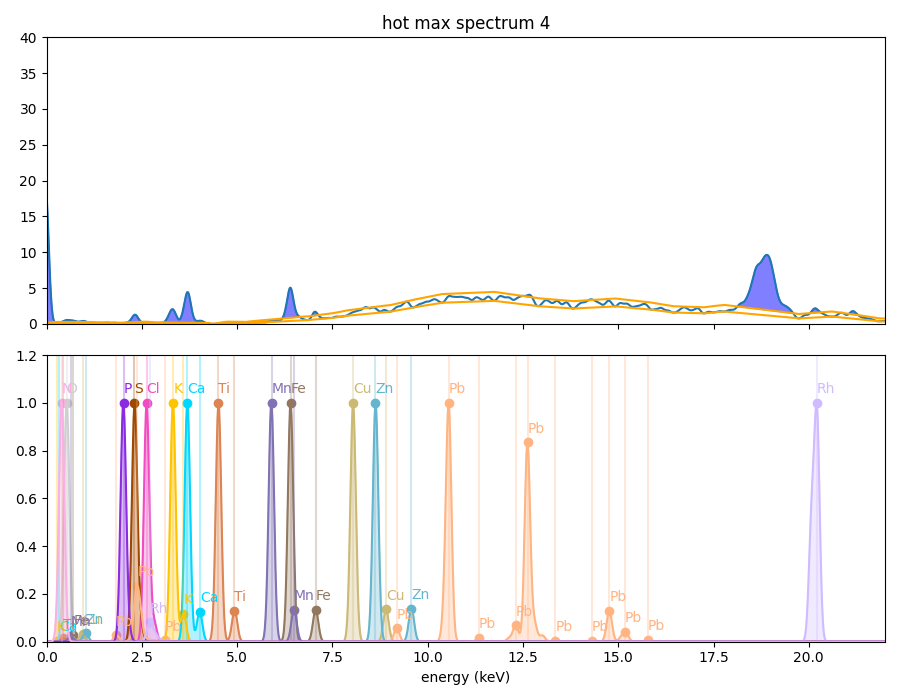

(0.0, 22.0)

In [ ]:
fig, [ax, ax1] = plt.subplots(nrows=2, sharex=True, figsize=[9, 7])

#ax3 = ax.twinx()
ax.plot(x_keVs, y) 
ax.plot(x_keVs, b, color='orange')
ax.plot(x_keVs, p, color='orange')
ax.fill_between(x_keVs, p, y, y > p, color='b', alpha=0.5)
ax.set_title(f'hot max spectrum {j}')
ax.set_ylim(0, 40)
#ax3.plot(x_keVs, (y - b)) 
#ax.set_ylim(0, 5)

elements = ['O', 'Cl', 'Ca', 'K', 'S', 'Ti', 'Fe', 'Cu', 'Zn', 'Pb', 'Rh', 'Mn', 'P', 'N']
#elements = ['S'] #, 'Pb']
[mos.XFluo(elem, tube_keV=40).plot(ax=ax1, peak_labels='simple') for elem in elements]
ax1.set_ylim(0, 1.2)
ax.set_xlim(0, 22)

Ok, should be possible to filter significant peaks...

In [ ]:
hot_max_spectrum = np.array(hot_spectra).max(axis=0) 

<IPython.core.display.Javascript object>


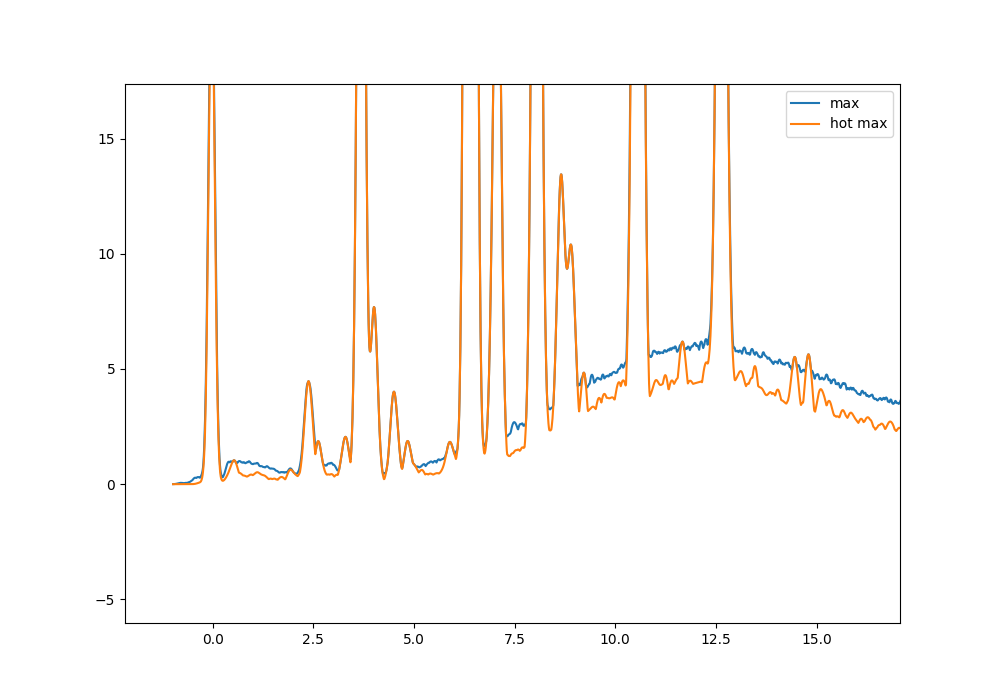

<matplotlib.legend.Legend>

In [ ]:
fig, ax = plt.subplots(figsize=[10, 7])
ax.plot(x_keVs, y_max, label='max')
ax.plot(x_keVs, hot_max_spectrum, label='hot max')
ax.legend()

In [ ]:
import matplotlib.cm as cm 
colors = cm.tab20(np.arange(24, dtype=int) % 20)

<IPython.core.display.Javascript object>


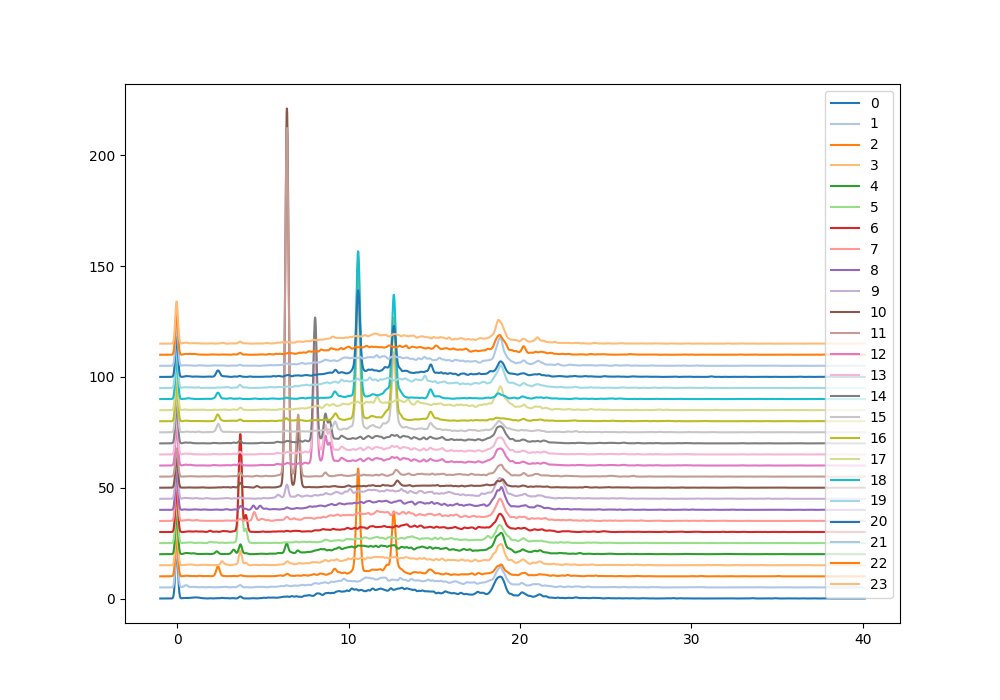

<matplotlib.legend.Legend>

In [ ]:
fig, ax = plt.subplots(figsize=[10, 7])

step = 5
for i, spectrum in enumerate(hot_spectra): 
    ax.plot(x_keVs, spectrum + i * step, label=i, color=colors[i])
    
ax.legend(loc='upper right')

Especially some smaller peaks are now better visible, as they do not drown in the baseline any more. The question is now how to detect the peaks and get rid of the baseline. Maybe it is more informative to do the peak detection and baseline correction on the individual hot max spectra.    

### Hot baseline correction 

Before trying some kind of decomposition, we need a generic baseline correction. 

<IPython.core.display.Javascript object>


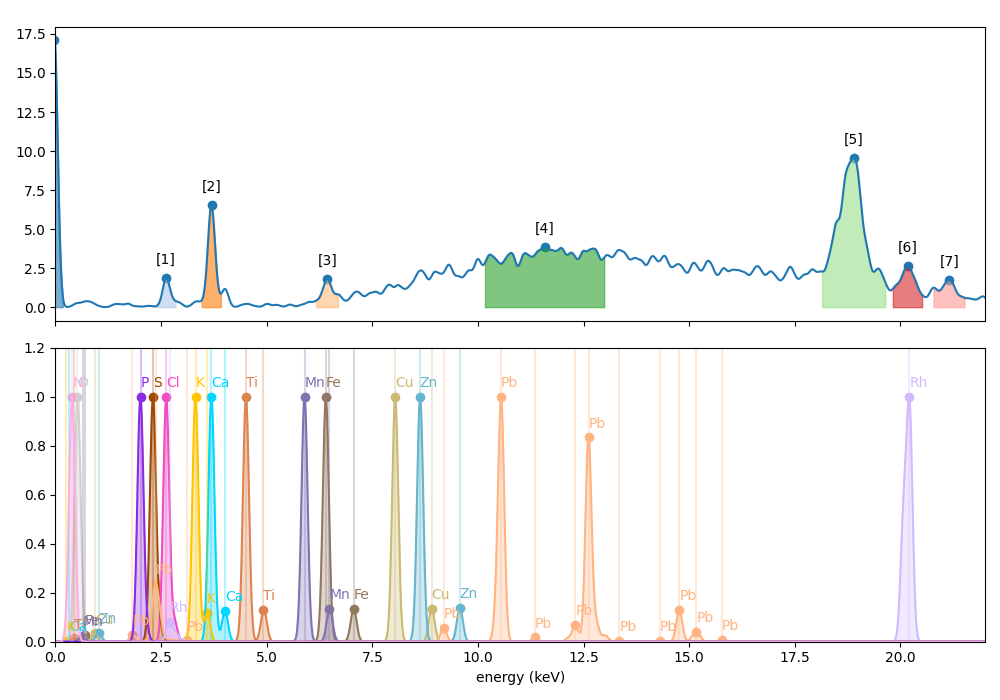

(0.0, 22.0)

In [ ]:
fig, [ax, ax1] = plt.subplots(nrows=2, sharex=True, figsize=[10, 7])

maxrf4u.plot_peak_slices(x_keVs, hot_spectra[3], ax=ax, prominence=1)
#ax.plot(x_keVs, hot_spectra[3])

elements = ['O', 'Cl', 'Ca', 'K', 'S', 'Ti', 'Fe', 'Cu', 'Zn', 'Pb', 'Rh', 'Mn', 'P', 'N']
#elements = ['S'] #, 'Pb']
[mos.XFluo(elem, tube_keV=40).plot(ax=ax1, peak_labels='simple') for elem in elements]
ax1.set_ylim(0, 1.2)
ax.set_xlim(0, 22)

Need to take a look at my baseline envelope algorithm. See: [notebook](http://localhost:8888/notebooks/Work/Projecten/Revigo/notebooks/2018-06-22-envelope-filtering-dev.ipynb). It seems that in our case Poisson noise is different. Here we can take an alternative approach based on a moving minimum filter. I am not aware of a readily available function, so let's build one.  

In [ ]:
import scipy.signal as ssg 
import scipy.interpolate as sip
import numpy as np

In [ ]:
y = hot_spectra[3]

peak_indices, shapes_dict = ssg.find_peaks(y, distance=20)
surge_indices, shapes_dict = ssg.find_peaks(-y, distance=20)

# append end points 

peak_indices = np.r_[0, peak_indices, -1]
surge_indices = np.r_[0, surge_indices, -1]

upper = sip.interp1d(x_keVs[peak_indices], y[peak_indices], kind='linear', bounds_error=False)
lower = sip.interp1d(x_keVs[surge_indices], y[surge_indices], kind='linear', bounds_error=False)



In [ ]:
test = np.arange(5)
np.r_[-1, test, len(test)]

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
test[[1, -1]]

array([1, 4])

In [ ]:
envelope = upper(x_keVs) - lower(x_keVs)

Due to Poisson statistics, the baseline noise is much greater at the Compton ridge maximum. I would like to take the noise standard deviation into account when detecting peaks... 

<IPython.core.display.Javascript object>


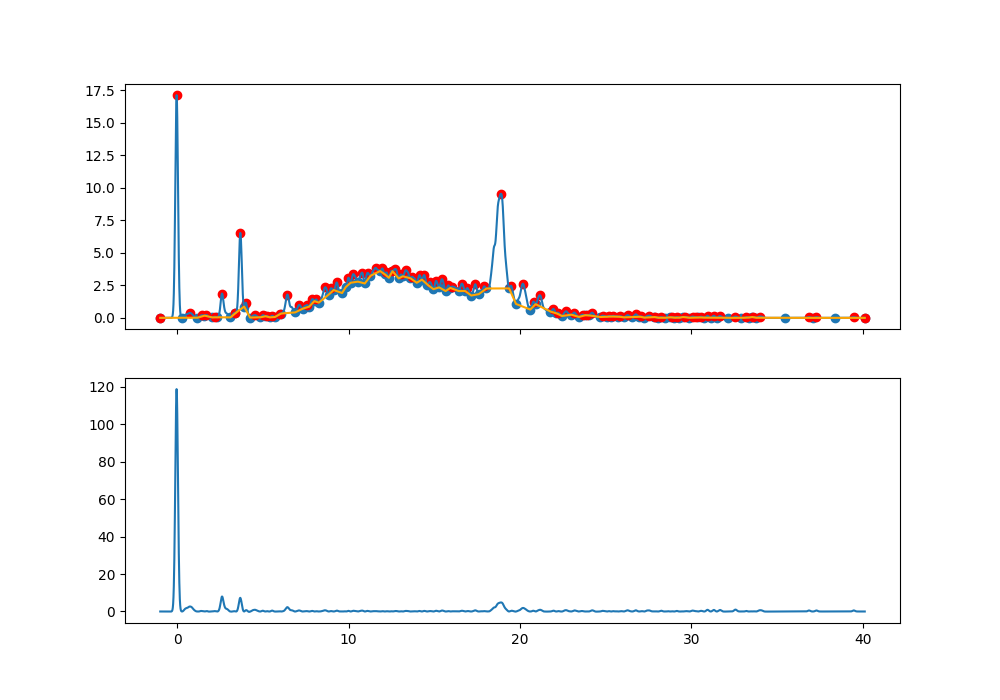

[<matplotlib.lines.Line2D>]

In [ ]:
fig, [ax, ax1] = plt.subplots(nrows=2, sharex=True, figsize=[10, 7])

ax.plot(x_keVs, y)
ax.scatter(x_keVs[surge_indices], y[surge_indices])
ax.scatter(x_keVs[peak_indices], y[peak_indices], color='r')

#ax.plot(x_keVs, upper(x_keVs), color='r')
ax.plot(x_keVs, lower(x_keVs), color='orange')

# Baseline Poisson normalized noise  
ax1.plot(x_keVs, (y - lower(x_keVs)) / np.sqrt(lower(x_keVs) + 0.01))

### Rolling ball baseline correction 

Using the distance map to calculate the baseline. 

Probably the most efficient code is making use of the numpy distance transform. We need to create a temporary mask. 

In [ ]:
import scipy.ndimage.morphology as morphology

def get_baseline(spectrum, radius=200, return_indices=False): 
    '''Calculate baseline for *spectrum* with rolling ball algorithm.  
    
    Use distance map to select only the lowest surges that touch the rolling ball.'''

    y_norm = y / y.max()
    
    w = len(y) 
    h = w // 2

    # initialize ramp with normalized spectrum in top half  
    ramp = np.ones([h, w]) * np.linspace(1, -1, h)[:, None]
    
    # create boolean mask from spectrum 
    spectrum_mask = ramp < y_norm 
    
    # create distance map for spectrum mask 
    dist_map, index_images = morphology.distance_transform_edt(spectrum_mask, return_indices=True)

    # we only need the second (x-axis) channel index image
    _, index_img = index_images 

    # roll the ball 
    ball_mask = dist_map < radius 
    ball_profile = ball_mask.sum(axis=0) 

    # get touching surges indices 
    lowest_indices = list(set(index_img[ball_profile, range(len(y))]))
    
    # create linear interpolation between the selected lowest surges (valleys)
    interpolation = sip.interp1d(x_keVs[lowest_indices], y[lowest_indices], bounds_error=False)
    baseline = interpolation(x_keVs) 
    
    if return_indices: 
        return baseline, lowest_indices 
    
    return baseline

In [ ]:
baseline, lowest_indices = get_baseline(y, return_indices=True)

<IPython.core.display.Javascript object>


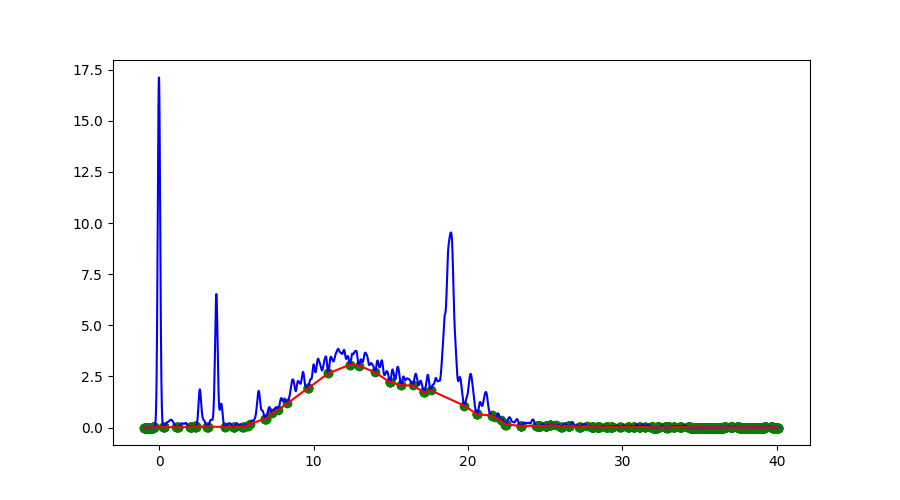

[<matplotlib.lines.Line2D>]

In [ ]:
fig, ax = plt.subplots(figsize=[9, 5])
ax.plot(x_keVs, y, color='b')
ax.scatter(x_keVs[lowest_indices], y[lowest_indices], color='g')
ax.plot(x_keVs, baseline, color='r')

<IPython.core.display.Javascript object>


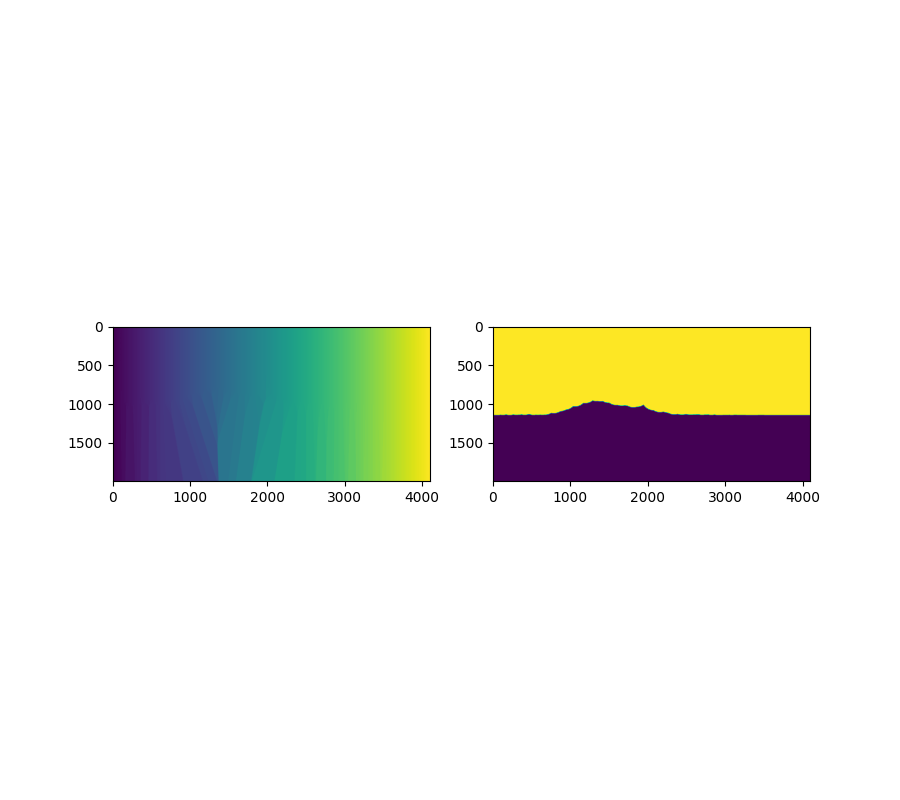

<matplotlib.image.AxesImage>

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[9,8])
ax.imshow(indices)
ax1.imshow(dist < 150)

In [ ]:
gaps = np.diff(surge_indices)

In [ ]:
np.argwhere(gaps == 171)

array([[82]])

In [ ]:
surge_indices[81]

3440

<IPython.core.display.Javascript object>


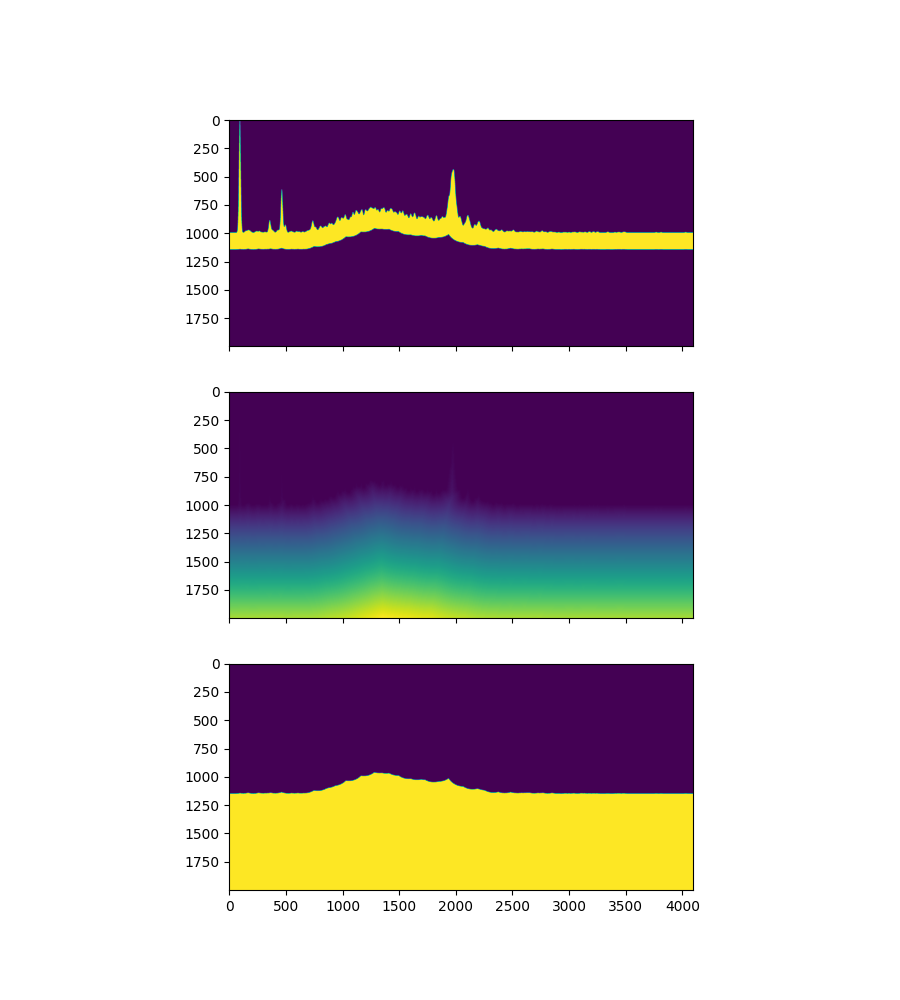

<matplotlib.image.AxesImage>

In [ ]:
fig, [ax, ax1, ax2] = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=[9, 10])
ax.imshow(is_above ^ (dist > 150))
ax1.imshow(dist)
ax2.imshow(dist > 150)

Next step is to plot contours...

### Hot NMF (Failed)

**Naive application of NMF decomposition seems to fail due to significant baseline noise. Another possibility would be the zero detector peak. Not checking this.** 

I think there is a good chance that we can sort/group the hot spectra with the NMF algorithm. So let's give that a try. 

Here is the sklearn documentation: [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

In [ ]:
# example 
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [ ]:
W

array([[0.        , 0.46880684],
       [0.55699523, 0.3894146 ],
       [1.00331638, 0.41925352],
       [1.6733999 , 0.22926926],
       [2.34349311, 0.03927954],
       [2.78981512, 0.06911798]])

In [ ]:
X = np.array(hot_spectra)
n_components, _ = X.shape

In [ ]:
model = NMF(n_components=n_components, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [ ]:
H.shape

(24, 4096)

<IPython.core.display.Javascript object>


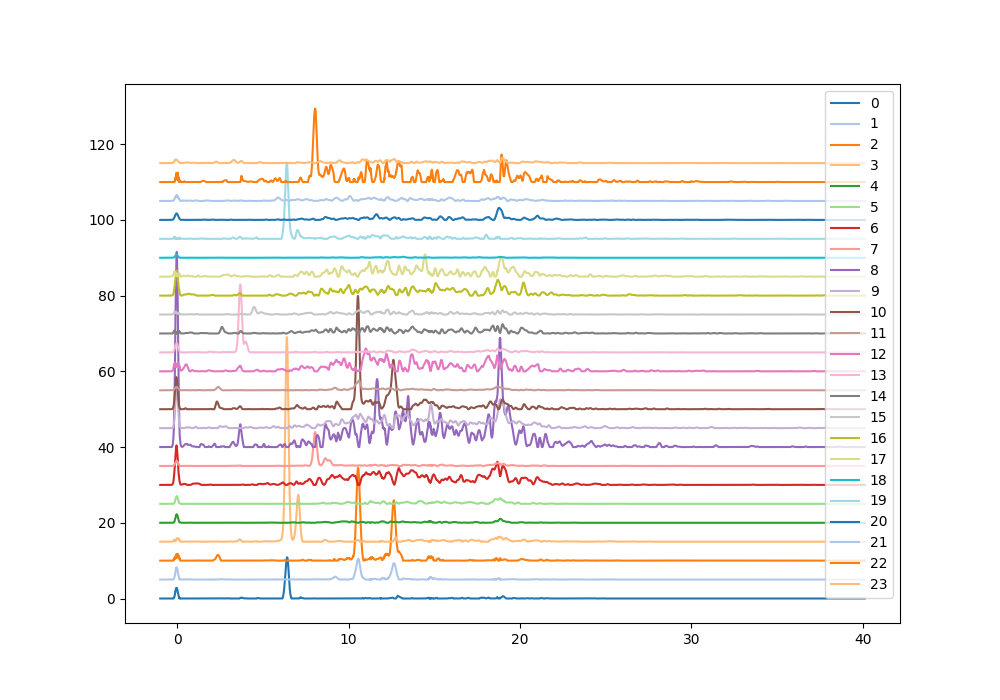

<matplotlib.legend.Legend>

In [ ]:
fig, ax = plt.subplots(figsize=[10, 7])

step = 5
for i, spectrum in enumerate(H): 
    ax.plot(x_keVs, spectrum + i * step, label=i, color=colors[i])
    
ax.legend(loc='upper right')

Mwah, the baseline noise is too important here. 

<IPython.core.display.Javascript object>


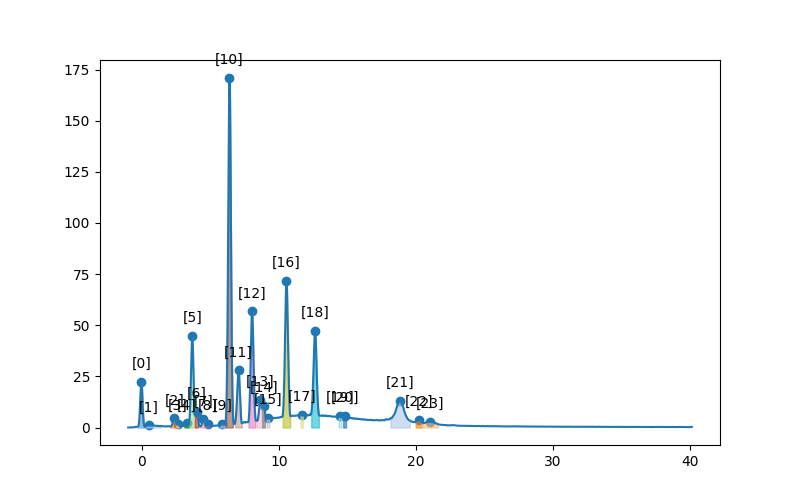

In [ ]:
maxrf4u.plot_peak_slices(x_keVs, y_max, prominence=0.35);

In this case we observe 22 peaks in the max spectrum that we would like to *explain away*. 

In [ ]:
import moseley as mos
import matplotlib.pyplot as plt 

<IPython.core.display.Javascript object>


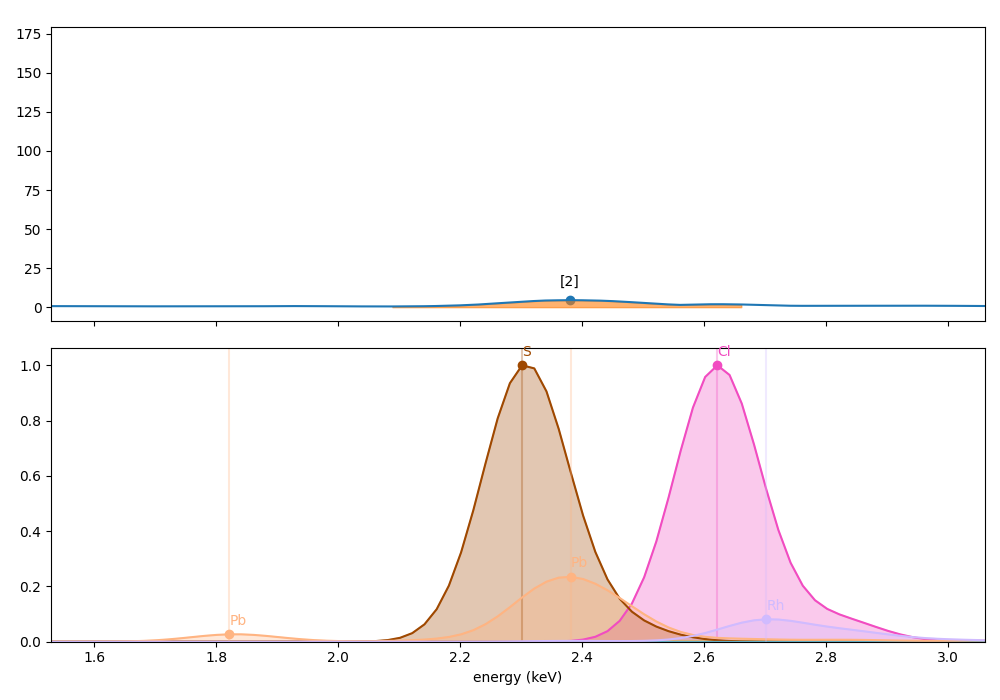

(0.0, 22.0)

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False, figsize=[10, 7])

maxrf4u.plot_peak_slices(x_keVs, y_max, ax=ax)

elements = ['O', 'Cl', 'Ca', 'K', 'S', 'Ti', 'Fe', 'Cu', 'Zn', 'Pb', 'Rh']
#elements = ['S'] #, 'Pb']
[mos.XFluo(elem, tube_keV=40).plot(ax=ax1, peak_labels='simple') for elem in elements]
ax1.set_ylim(0, 1.55)
ax.set_xlim(0, 22)

## Peak maps

### `maxrf4u.peak_maps.py`

In [ ]:
%%writefile /home/frank/Work/Projecten/DoRe/code/maxrf4u/peak_maps.py 

import scipy.signal as ssg 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm


def get_slices(x_calib, y_max, prominence=0.5, rel_height=0.2):  
    '''Returns: *peaks_xy*, *slices*'''

    # peak positions and properties 
    peak_indices, shapes_dict = ssg.find_peaks(y_max, prominence=prominence)
    peaks_x, peaks_y = x_calib[peak_indices], y_max[peak_indices]
    ip_widths, heights, left_ips, right_ips = ssg.peak_widths(y_max, peak_indices, rel_height=rel_height) 

    # estimate peak bases 2 x 2 x width at rel_height 0.2  
    dx = x_calib[1] - x_calib[0]
    left_bases = peaks_x -  2 * dx * ip_widths
    right_bases = peaks_x +  2 * dx * ip_widths 

    # find nearest index positions 
    left_bases_idx = np.array([np.argmin((x_calib - lb)**2) for lb in left_bases]) 
    right_bases_idx = np.array([np.argmin((x_calib - rb)**2) for rb in right_bases]) 

    # combine 
    peaks_xy = np.c_[peaks_x, peaks_y]
    slices = np.c_[left_bases_idx, peak_indices, right_bases_idx]
    
    return peaks_xy, slices



def get_peakmaps(arr, x_calib, y_max, prominence=0.5, rel_height=0.2, norm=True): 
    '''Integrate peak slices into peak maps and keV maps. 
    
    Returns: peak_maps, keV_maps'''
    
    peaks_xy, slices = get_slices(x_calib, y_max, prominence=prominence, rel_height=rel_height)

    peak_maps = []
    keV_maps = []

    for i, [si, sj, sk] in enumerate(slices): 
        
        print(f'{i}/{len(slices)}', end='\r')
    
        peak_slice = arr[:,:,si:sk+1].compute()
        d = sk - si 
        
        peak_map = np.sum(peak_slice, axis=2) / d - (peak_slice[:,:,0] + peak_slice[:,:,-1]) / 2 
        
        if norm:  
            peak_map = peak_map / peak_map.max()
            # no clipping to study better the low signal noise 
            # peak_map = np.clip(peak_map, a_min=0, a_max=1)
        
        keV_idx_map = si + np.argmax(peak_slice, axis=2)
        keV_map = x_calib[keV_idx_map]

        peak_maps.append(peak_map) 
        keV_maps.append(keV_map)
        
    return peak_maps, keV_maps 



def plot_peak_slices(x_calib, y_max, ax=None, prominence=0.5, rel_height=0.2, 
                     grid=False, labels='simple', figsize=[8, 5]): 
    '''Utility function to plot the results of get_slices()'''
    
    peaks_xy, slices = get_slices(x_calib, y_max, prominence=prominence, rel_height=rel_height)
    zero = np.zeros_like(x_calib) 

    if ax is None: 
        fig, ax = plt.subplots(figsize=figsize)    
    else: 
        fig = ax.get_figure()
        
    ax.plot(x_calib, y_max)
    
    if labels is 'simple': 
        peak_labels = [f'[{i}]' for i in range(len(peaks_xy))]    
    elif labels is 'full': 
        peak_labels = [f'[{i}]\n{keV:.03f}keV' for i, [keV, _] in enumerate(peaks_xy)]    
    else: 
        assert False, 'Option labels=  can be "simple" or "full"'        

    [ax.annotate(s, xy, xytext=(0, 10), ha='center', textcoords='offset points') for s, xy in zip(peak_labels, peaks_xy)]

    ax.scatter(*peaks_xy.T)
    if grid: 
        ax.grid()

    # colorize peak slices 
    n_slices = len(slices) 
    colors = cm.tab20(np.arange(n_slices) % 20)
    
    
    [ax.fill_between(x_calib, zero, y_max, alpha=0.6, color=color, 
                     where=np.r_[np.zeros(i), np.ones(k - i), np.zeros(len(x_calib) - k)]) 
     for [i, j, k], color in zip(slices, colors)];
    
    return fig, ax 




Overwriting /home/frank/Work/Projecten/DoRe/code/maxrf4u/peak_maps.py


In [ ]:
# force deep reload 
import maxrf4u
import sys

del sys.modules['maxrf4u.storage']
del sys.modules['maxrf4u.calibration']
del sys.modules['maxrf4u.peak_maps']
del sys.modules['maxrf4u']

import maxrf4u

### Slicing the cube into peak maps 

Different elements that are present in the artwork emit x-ray induced fluorescence at characteristic wavelengths. Let's start with an inspection of the max spectrum to see at which energy bands we find emission peaks.  

In [ ]:
ds = maxrf4u.DataStack('RP-T-1898-A-3689.datastack')

In [ ]:
peaks_xy, slices = maxrf4u.get_slices(ds.energies(), ds.max_spectrum())

In [ ]:
import matplotlib.pyplot as plt 
import myutils as mu 

def multi_plot(*images, titles=None, axis_off=False, fig_width=9, 
               sharex=True, sharey=True, vmin=None, vmax=None, cmap='Greys_r', 
               fontsize='xx-large', zoom_xyc=None, zoom_half_wh=[100, 100]): 
    '''Inspect multiple images simultaneously... 
    
    Fold along multiple rows if n > 4'''
    
    nrows_max = 4 
    n_img = len(images)
    
    nrows = (n_img // nrows_max) # completely filled rows 
    rest = n_img % nrows_max 
    if rest != 0:
        nrows = nrows + 1
    
    if n_img <= nrows_max: 
        ncols = n_img
    else: 
        ncols = nrows_max
        
    figsize = [fig_width, fig_width/2 + 2 * (nrows -1)]
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False, sharex=sharex, sharey=sharey)
    
    for i, img in enumerate(images): 
    
        axs.flatten()[i].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
            
    if titles is not None:
        for i, t in enumerate(titles): 
            axs.flatten()[i].set_title(t, fontsize=fontsize)
    
    if axis_off: 
        axs_flat = axs.flatten()
        for ax in axs_flat: 
            ax.set_axis_off()
            
    # remove (ugly) empty subplots 
    for ax in axs.flatten()[n_img:nrows*ncols]: 
        ax.remove()
        
    fig.subplots_adjust(hspace=0.4, wspace=0.4)    
            
    plt.tight_layout()
    
    return fig, axs 

In [ ]:
peak_maps, keV_maps = maxrf4u.get_peakmaps(ds.maxrf_cube, ds.energies(), ds.max_spectrum())

In [ ]:
remarks = ['[0] ?', '[1] ?', '[2] S_KL2+Pb_M5O2','[3] K_KL2', '[4] Ca_KL3', '[5] Ca_KM2', 
           '[6] Ti_KL2', '[7] ?', '[8] ?', '[9] Fe_KL3', '[10] Fe_KM2', '[11] Cu_KL2', '[12] Zn_KL3', 
           '[13] Cu_KM2', '[14] Pb_L3M1', '[15] Pb_L3M5', '[16] Pb_L3N4', '[17] ?', '[18] Pb_L2N4', '[19] Compton Rh_Ka', 
           '[20] Rh_KL3', '[21] Compton Rh_Kb']  

titles = [f'{rem} {keV:.02f}' for rem, keV in zip(remarks, peaks_xy[:,0])]

In [ ]:
peak_maps_histeq = [mu.histeq(pm) for pm in peak_maps]

<IPython.core.display.Javascript object>


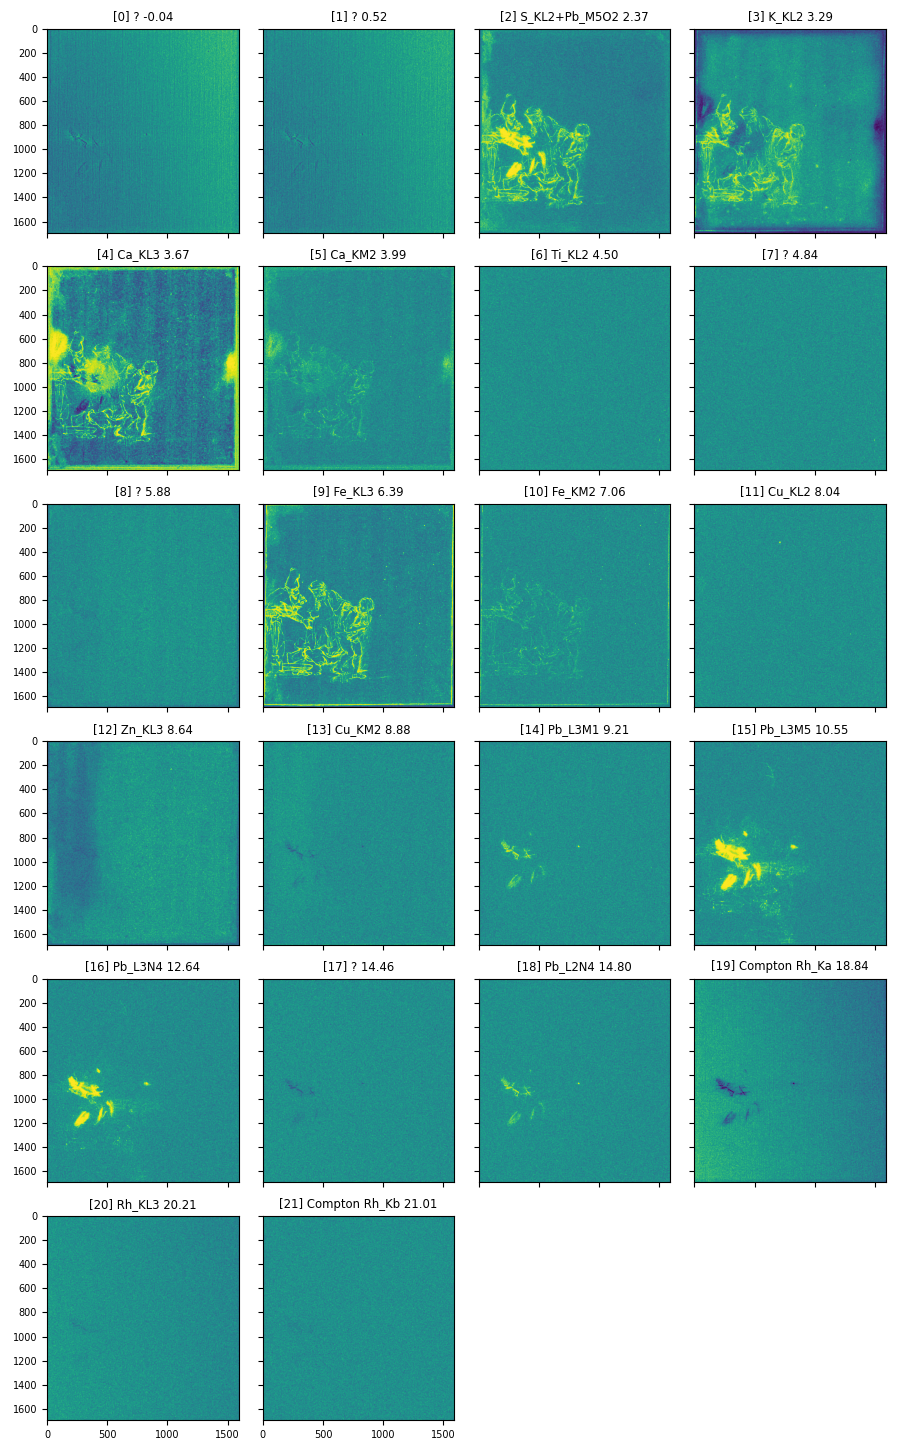

In [ ]:
fig, axs = multi_plot(*peak_maps_histeq, titles=titles, fontsize='large', cmap='viridis', axis_off=False);

In [ ]:
axs.flatten()[-1].remove()

In [ ]:
plu.multi_plot?

In [ ]:
def get_noise_level(peak_map, noise_frac=0.5): 
    '''Estimates noise level from negative noise. 
    
    Returns: *noise_level*, *is_negative*'''
    
    is_negative = peak_map < 0 

    # determine cumulative negative noise level distribution 
    res = sstats.cumfreq(peak_map[is_negative], numbins=10)

    bins = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)
    hist = 1 - res.cumcount / res.cumcount.max() 

    level_i = np.argmin((hist - noise_frac)**2)
    noise_level = -bins[level_i] 

    return noise_level, is_negative 

In [ ]:
ds = maxrf4u.DataStack('RP-T-1898-A-3689.datastack')

x_keVs = ds.energies()
y_max = ds.max_spectrum()

<IPython.core.display.Javascript object>


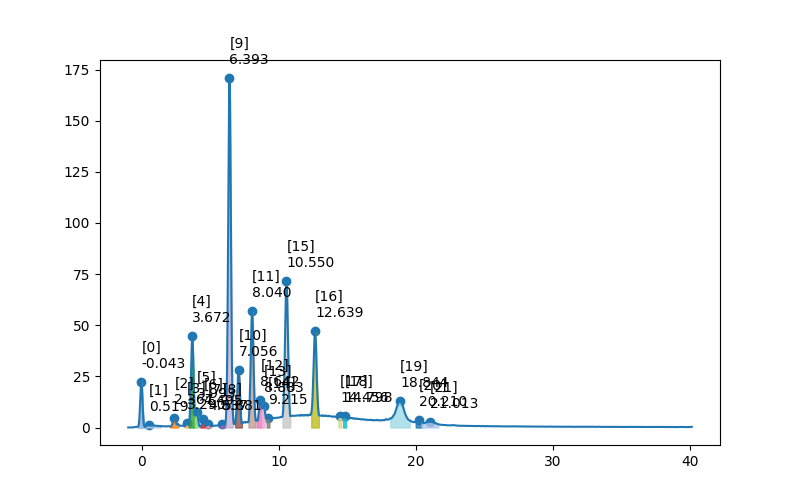

In [ ]:
plot_peak_slices(x_keVs, y_max);

In [ ]:
get_slices(x_keVs, y_max)

## Iron segmentation 

Before doing anything else, such as image registration or a speckle atlas, it is necessary to segment the iron map into speckles+ink+paper...    

See again: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py

## Speckles 

### Interesting and annoying speckles 

### `maxrf4u.speckles.py` 

In [ ]:
import skimage.measure as skm 
import numpy as np 

class SpeckleAtlas(): 
    
    def __init__(self, peak_map, n_heights=100): 
        
        
        self.peak_map = peak_map 
        
        h, w = self.peak_map.shape
        self.n_px =  h * w 
        
        self.heights = np.linspace(peak_map.min(), peak_map.max(), n_heights)
        
        # perhaps better just iterate 
        height_maps = [self.peak_map > h for h in self.heights] 

        largest_area_list = [] 
        largest_label_list = []
        n_regions_list = []

        for i, hm in enumerate(height_maps): 

            print(f'Inspecting height slice: {i}/{n_heights}', end='\r')

            label_image = skm.label(height_maps[i].astype(int), connectivity=1)
            props = skm.regionprops(label_image)
            n_regions_list.append(len(props))
            areas_labels = np.array([[p.area, p.label] for p in props])

            label_image = skm.label(height_maps[i], connectivity=1)

            props = skm.regionprops(label_image)

            areas_labels = np.array([[p.area, p.label] for p in props])

            # in case of zero regions:  
            if len(areas_labels) == 0: 
                areas_labels = np.array([[0, 0]])

            areas, labels = areas_labels.T

            largest_area_i = np.argmax(areas)
            largest_area = areas[largest_area_i]
            largest_label = labels[largest_area_i]

            largest_area_list.append(largest_area)
            largest_label_list.append(largest_label) 
                
        
        self.largest_areas = largest_area_list   
        self.largest_labels = largest_label_list 
        self.n_regions = n_regions_list 

    def measure_speckles(self, max_area=100): 
        '''Find, sort, label and measure speckle regions.  
        
        Selects lowest height slice with all speckle regions smaller then *max_area*. 
        
        Returns: *clip_height* '''
        
        # find largest speckle and associated clip height 
        self.max_area = max_area 
        self.clip_height_i = np.argmin((np.array(self.largest_areas) - max_area)**2) 
        self.clip_height = self.heights[self.clip_height_i] 
        self.largest_speckle_label = self.largest_labels[self.clip_height_i] 
        
        # unsorted label image for clip level  
        unsorted_label_image = skm.label(self.peak_map > self.clip_height)
        uprops = skm.regionprops(unsorted_label_image) 

        u_areas = np.array([p.area for p in uprops])
        u_labels = np.array([p.label for p in uprops]) # [1, 2, 3 ...]

        # create area sorted labels 
        indices = np.argsort(u_areas)[::-1]
        area_sorted_labels = u_labels[indices]

        #prepend zero index for background 
        area_sorted_labels_bg = np.r_[0, area_sorted_labels]
        
        # make relabel lut 
        n_labels = len(area_sorted_labels_bg)
        relabel_lut = np.zeros(n_labels, dtype=int)
        
        # say region with label 123 is largest speckle 
        # then lut[123] = 1 
        relabel_lut[area_sorted_labels_bg] = np.arange(n_labels)
        
        # took me quite some time to debug so let's make sure next time 
        assert relabel_lut[area_sorted_labels_bg[1]] == 1, 'Relabeling of image went wrong' 
        
        self.relabel_image = relabel_lut[unsorted_label_image] 
        
        # determine region props 
        self.props = skm.regionprops(self.relabel_image, intensity_image=self.peak_map)
        
        self.centroids_y, self.centroids_x = np.array([p.centroid for p in self.props]).T
        self.centroids_xy = np.c_[self.centroids_x, self.centroids_y]
                                  
        return self.clip_height 
    
    
    def speckle_spectrum(self, arr, speckle_i): 
        '''Get averaged speckle spectrum for region of *speckle_i*. 
        
        Returns: *spectrum*
        -------
        '''

        print(speckle_i, end='\r')

        p = self.props[speckle_i]
        
        spectrum = region_spectra(arr, mask=p.image, average=True)
               
        return spectrum 
    

In [ ]:
peak_maps, keV_maps = maxrf4u.get_peakmaps(ds.maxrf_cube, ds.energies(), ds.max_spectrum())

In [ ]:
iron = peak_maps[9]

In [ ]:
iron.max()

1.0

<IPython.core.display.Javascript object>


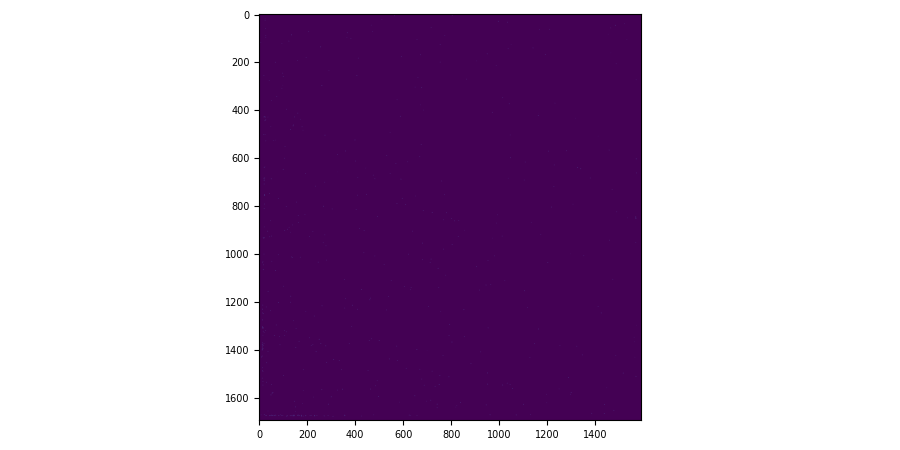

(<Figure size 900x450 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

In [ ]:
multi_plot(iron, vmax=0.03)

In [ ]:
sa = SpeckleAtlas(iron)

In [ ]:
sa.measure_speckles()

0.03513991471492883

In [ ]:
speckles_x, speckles_y = sa.centroids_xy.T

<IPython.core.display.Javascript object>


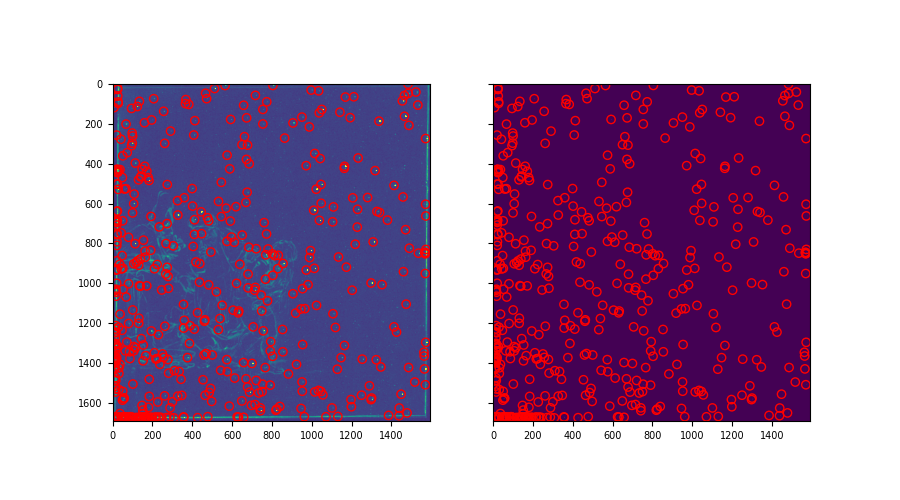

<matplotlib.image.AxesImage>

In [ ]:
fig, axs = plt.subplots(ncols=2, squeeze=True, sharex=True, sharey=True, figsize=[9, 5])
ax, ax1 = axs 
ax.imshow(iron, vmax=0.03)
ax1.scatter(speckles_x, speckles_y, facecolor='none', edgecolor='r')
ax.scatter(speckles_x, speckles_y, facecolor='none', edgecolor='r')
ax1.imshow(sa.relabel_image)

In [ ]:
sa.relabel_image.max()

495

Is it possible to get a sum image that can be used for image registration? 

In [ ]:
h, w, n = ds.maxrf_cube.shape

In [ ]:
sum_image = ds.maxrf_cube[:,:,100:n].sum(axis=2)

In [ ]:
sum_im = sum_image.compute()

In [ ]:
sum_im = sum_im / n

In [ ]:
maxrf4u.IRON_Ka

6.4032016008004

In [ ]:
peaks_xy

array([[-4.33671381e-02,  2.24201965e+01],
       [ 5.18950384e-01,  1.03660882e+00],
       [ 2.36656510e+00,  4.47129393e+00],
       [ 3.29037246e+00,  2.05318689e+00],
       [ 3.67194506e+00,  4.46399460e+01],
       [ 3.99326936e+00,  7.68807507e+00],
       [ 4.49533858e+00,  4.01460123e+00],
       [ 4.83674565e+00,  1.87345469e+00],
       [ 5.88104962e+00,  1.83583868e+00],
       [ 6.39316022e+00,  1.71131897e+02],
       [ 7.05589158e+00,  2.79770107e+01],
       [ 8.03994725e+00,  5.68118744e+01],
       [ 8.64243031e+00,  1.34473858e+01],
       [ 8.88342353e+00,  1.04026098e+01],
       [ 9.21478921e+00,  4.83900642e+00],
       [ 1.05502933e+01,  7.17649231e+01],
       [ 1.26389013e+01,  4.70944862e+01],
       [ 1.44563918e+01,  5.52164507e+00],
       [ 1.47977989e+01,  5.63242197e+00],
       [ 1.88444768e+01,  1.28910427e+01],
       [ 2.02101051e+01,  3.87582064e+00],
       [ 2.10134158e+01,  2.87180996e+00]])

In [ ]:
list(ds.energies()).index(maxrf4u.IRON_Ka)

737

<IPython.core.display.Javascript object>


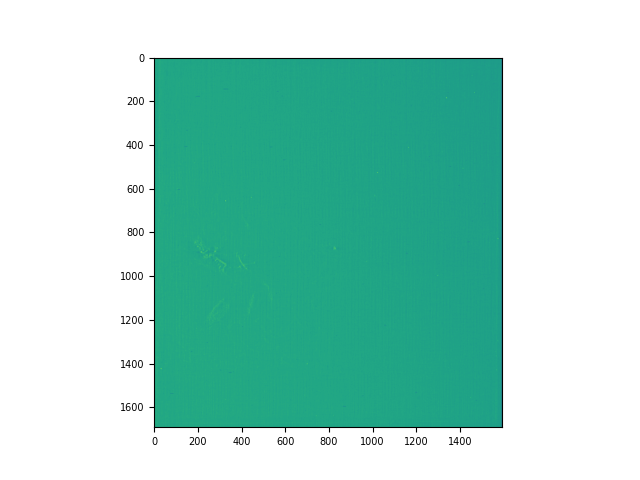

<matplotlib.image.AxesImage>

In [ ]:
fig, ax = plt.subplots()
ax.imshow(sum_im)